In [2]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, LSTM, GRU
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from sklearn.metrics import mean_absolute_percentage_error
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error

# DATA PREPOCESSING

## DATA CLEANING

In [4]:
df = pd.read_excel('/content/dataset_capstone_project.xlsx')
df.head()

,Tahun,Bulan,Tanggal,Beras,Cabai Merah,Cabai Merah Keriting,Cabai Rawit,Cabai Rawit Hijau,Cabai Rawit Merah,Bawang Merah,Bawang Putih
0,2021,1,4,11750,61250,62500,72500,60000,85000,31750,28500
1,2021,1,5,11750,61250,62500,73750,60000,87500,31750,28500
2,2021,1,6,11750,61250,62500,73750,60000,87500,31750,28500
3,2021,1,7,11750,61250,62500,75000,62500,87500,31750,28500
4,2021,1,8,11750,61250,62500,75000,62500,87500,31750,28500


In [5]:
print(df.dtypes)

Tahun                    int64
Bulan                    int64
Tanggal                  int64
Beras                   object
Cabai Merah             object
Cabai Merah Keriting    object
Cabai Rawit             object
Cabai Rawit Hijau       object
Cabai Rawit Merah       object
Bawang Merah            object
Bawang Putih            object
dtype: object


In [6]:
# Mengonversi kolom objek ke tipe data integer
for column in df.columns:
    if df[column].dtype == 'object':
        df[column] = pd.to_numeric(df[column], errors='coerce', downcast='integer')

# Menampilkan tipe data kolom setelah konversi
print(df.dtypes)

Tahun                     int64
Bulan                     int64
Tanggal                   int64
Beras                   float64
Cabai Merah             float64
Cabai Merah Keriting    float64
Cabai Rawit             float64
Cabai Rawit Hijau       float64
Cabai Rawit Merah       float64
Bawang Merah            float64
Bawang Putih            float64
dtype: object


In [7]:
# Mengganti nama kolom sesuai dengan yang diharapkan pandas
df.rename(columns={"Tahun": "year", "Bulan": "month", "Tanggal": "day"}, inplace=True)

# Menggabungkan kolom Tanggal, Bulan, Tahun menjadi satu kolom datetime
df["Tanggal Lengkap"] = pd.to_datetime(df[["year", "month", "day"]])

print(df)

     year  month  day    Beras  Cabai Merah  Cabai Merah Keriting  \
0    2021      1    4  11750.0      61250.0               62500.0   
1    2021      1    5  11750.0      61250.0               62500.0   
2    2021      1    6  11750.0      61250.0               62500.0   
3    2021      1    7  11750.0      61250.0               62500.0   
4    2021      1    8  11750.0      61250.0               62500.0   
..    ...    ...  ...      ...          ...                   ...   
883  2024      5   23  14700.0      55000.0               52500.0   
884  2024      5   24  14700.0      55000.0               52500.0   
885  2024      5   27  14700.0      56250.0               52500.0   
886  2024      5   28  14700.0      56250.0               52500.0   
887  2024      5   29  14700.0      56250.0               52500.0   

     Cabai Rawit  Cabai Rawit Hijau  Cabai Rawit Merah  Bawang Merah  \
0        72500.0            60000.0            85000.0       31750.0   
1        73750.0           

In [8]:
# Mengganti nama kolom sesuai dengan yang diharapkan pandas
df.rename(columns={"month": "month", "day": "day"}, inplace=True)

# Menggabungkan kolom Tanggal, Bulan, Tahun menjadi satu kolom datetime
df["Tanggal Lengkap"] = pd.to_datetime(df[["year", "month", "day"]])

# Menghapus kolom 'year', 'month', 'day', dan 'Tanggal Lengkap'
df = df.drop(columns=["year", "month", "day"])

print(df)

       Beras  Cabai Merah  Cabai Merah Keriting  Cabai Rawit  \
0    11750.0      61250.0               62500.0      72500.0   
1    11750.0      61250.0               62500.0      73750.0   
2    11750.0      61250.0               62500.0      73750.0   
3    11750.0      61250.0               62500.0      75000.0   
4    11750.0      61250.0               62500.0      75000.0   
..       ...          ...                   ...          ...   
883  14700.0      55000.0               52500.0      56250.0   
884  14700.0      55000.0               52500.0      56250.0   
885  14700.0      56250.0               52500.0      56250.0   
886  14700.0      56250.0               52500.0      56250.0   
887  14700.0      56250.0               52500.0      56250.0   

     Cabai Rawit Hijau  Cabai Rawit Merah  Bawang Merah  Bawang Putih  \
0              60000.0            85000.0       31750.0       28500.0   
1              60000.0            87500.0       31750.0       28500.0   
2           

In [9]:
df.isnull().sum()

Beras                   30
Cabai Merah             30
Cabai Merah Keriting    30
Cabai Rawit             30
Cabai Rawit Hijau       30
Cabai Rawit Merah       30
Bawang Merah            30
Bawang Putih            30
Tanggal Lengkap          0
dtype: int64

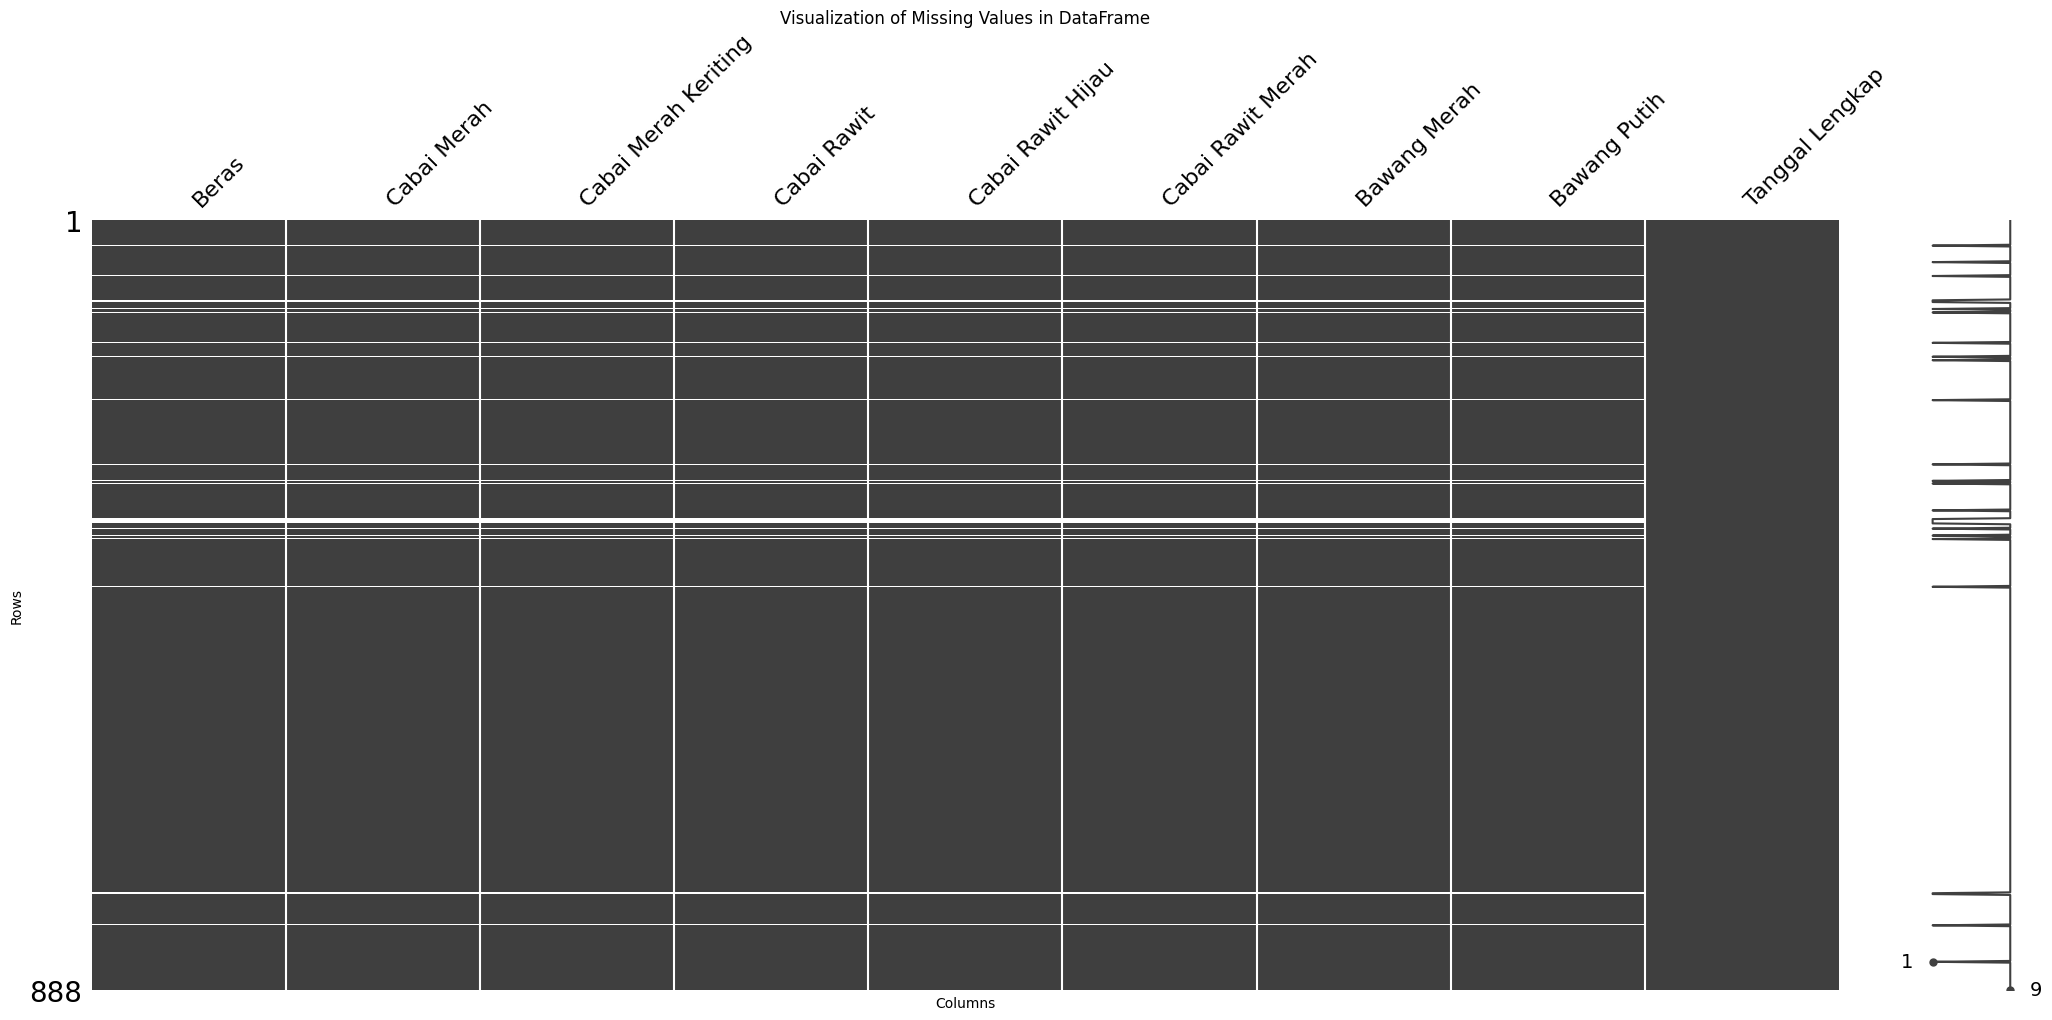

In [10]:
import missingno as msno
msno.matrix(df)
plt.title('Visualization of Missing Values in DataFrame')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()

In [11]:
def nearest_interpolation_imputation(df, columns):
    for col in columns:
        df[col] = df[col].interpolate(method='nearest')
    return df

# Menggunakan nearest_interpolation_imputation untuk mengisi missing values
df = nearest_interpolation_imputation(df, ['Beras', 'Cabai Merah', 'Cabai Merah Keriting', 'Cabai Rawit', 'Cabai Rawit Hijau', 'Cabai Rawit Merah', 'Bawang Merah', 'Bawang Putih'])

# Menampilkan DataFrame setelah imputasi
print(df)


       Beras  Cabai Merah  Cabai Merah Keriting  Cabai Rawit  \
0    11750.0      61250.0               62500.0      72500.0   
1    11750.0      61250.0               62500.0      73750.0   
2    11750.0      61250.0               62500.0      73750.0   
3    11750.0      61250.0               62500.0      75000.0   
4    11750.0      61250.0               62500.0      75000.0   
..       ...          ...                   ...          ...   
883  14700.0      55000.0               52500.0      56250.0   
884  14700.0      55000.0               52500.0      56250.0   
885  14700.0      56250.0               52500.0      56250.0   
886  14700.0      56250.0               52500.0      56250.0   
887  14700.0      56250.0               52500.0      56250.0   

     Cabai Rawit Hijau  Cabai Rawit Merah  Bawang Merah  Bawang Putih  \
0              60000.0            85000.0       31750.0       28500.0   
1              60000.0            87500.0       31750.0       28500.0   
2           

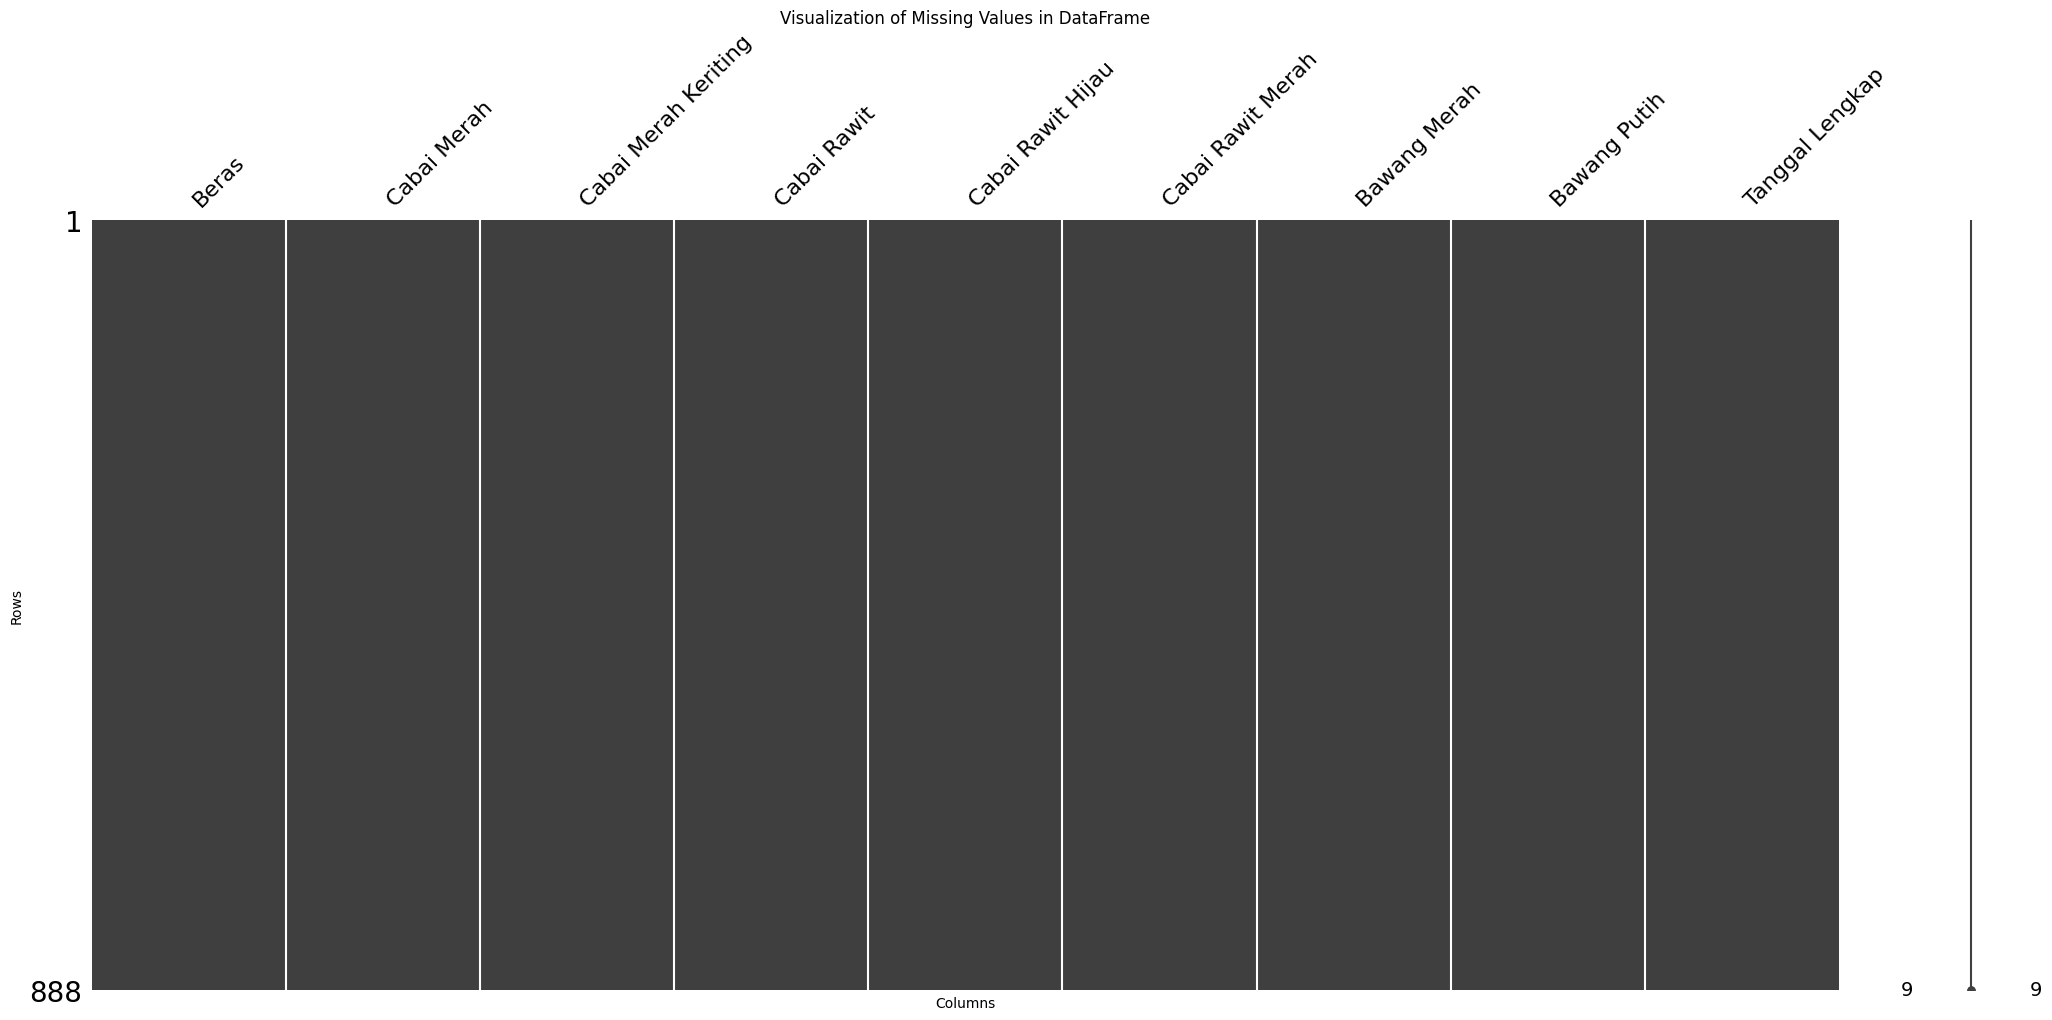

In [12]:
import missingno as msno
msno.matrix(df)
plt.title('Visualization of Missing Values in DataFrame')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()

In [13]:
df.isnull().sum()

Beras                   0
Cabai Merah             0
Cabai Merah Keriting    0
Cabai Rawit             0
Cabai Rawit Hijau       0
Cabai Rawit Merah       0
Bawang Merah            0
Bawang Putih            0
Tanggal Lengkap         0
dtype: int64

In [14]:
df.to_csv("data_clean.csv", index=False)

## Exploratory Data Analysis

In [15]:
df.describe()

,Beras,Cabai Merah,Cabai Merah Keriting,Cabai Rawit,Cabai Rawit Hijau,Cabai Rawit Merah,Bawang Merah,Bawang Putih,Tanggal Lengkap
count,888.000000,888.000000,888.000000,888.000000,888.000000,888.000000,888.000000,888.000000,888
mean,12835.078829,58458.558559,55454.673423,58683.558559,53178.490991,64177.927928,37970.157658,32489.020270,2022-09-16 02:25:56.756756992
min,11750.000000,30650.000000,28750.000000,29400.000000,28750.000000,30000.000000,26250.000000,27500.000000,2021-01-04 00:00:00
25%,11750.000000,46250.000000,42500.000000,45000.000000,42500.000000,47500.000000,32250.000000,28500.000000,2021-11-09 18:00:00
50%,12200.000000,54400.000000,52500.000000,57500.000000,52500.000000,60000.000000,36500.000000,29250.000000,2022-09-15 12:00:00
75%,13500.000000,65000.000000,62500.000000,71250.000000,62500.000000,77500.000000,41250.000000,37500.000000,2023-07-24 06:00:00
max,16050.000000,118750.000000,117500.000000,100000.000000,92500.000000,115000.000000,71250.000000,47500.000000,2024-05-29 00:00:00
std,1207.529830,18721.140284,18752.372660,17031.719197,14190.778528,21260.315154,8400.502560,5626.925871,NaN


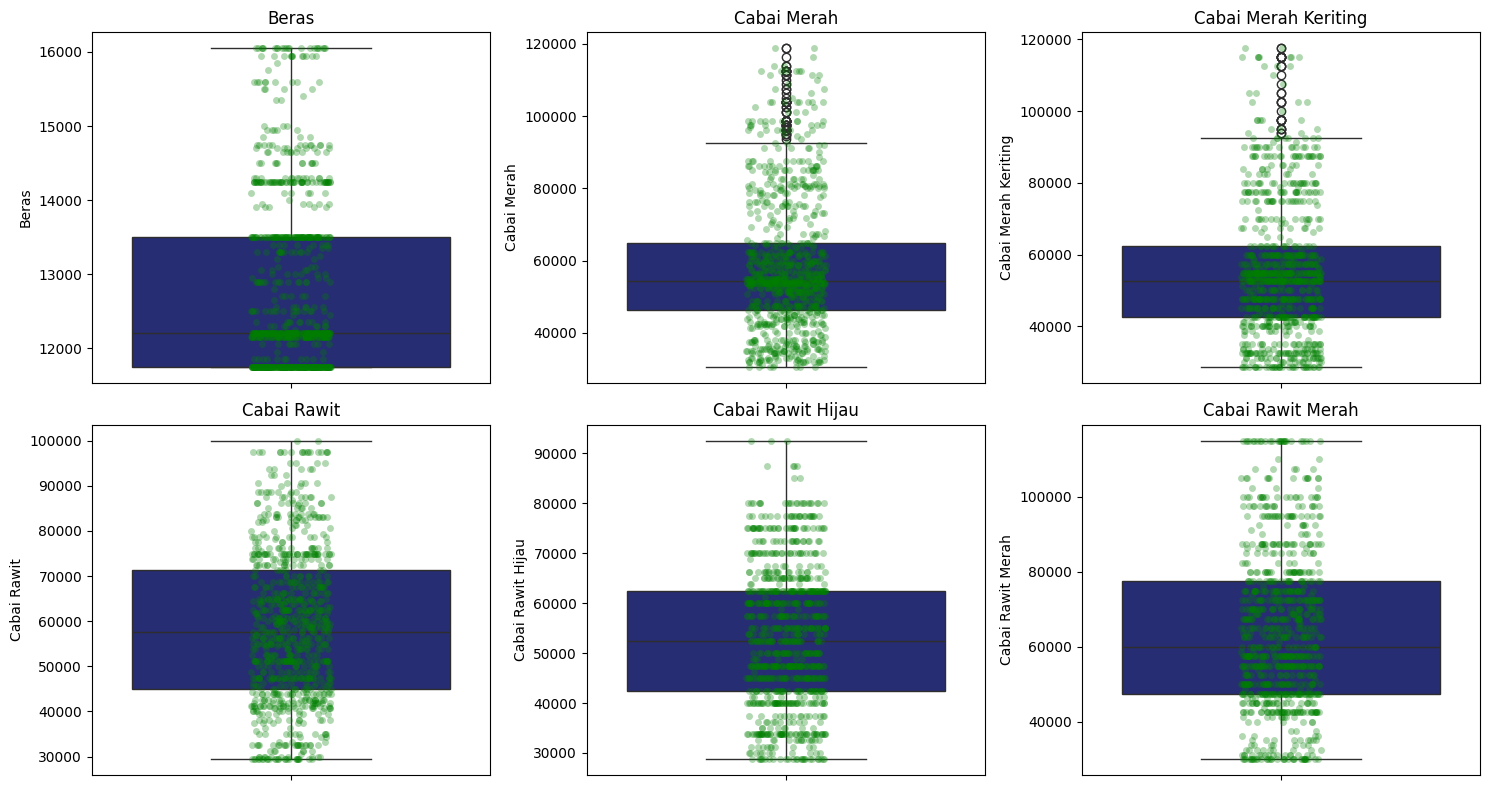

In [16]:
boxplot_color = "#1A237E"
stripplot_color = "green"
numerical_col = ["Beras",	"Cabai Merah", "Cabai Merah Keriting", "Cabai Rawit",	"Cabai Rawit Hijau",	"Cabai Rawit Merah"]
num_variables = len(numerical_col)
num_rows = 2
num_cols = (num_variables + num_rows - 1) // num_rows

plt.figure(figsize=(15, 8))

for i, variable in enumerate(numerical_col):
    plt.subplot(num_rows, num_cols, i+1)
    sns.boxplot(y=df[variable], whis=1.5, color=boxplot_color)
    sns.stripplot(y=df[variable], color=stripplot_color, jitter=True, alpha=0.3)
    plt.title(variable)

plt.tight_layout()
plt.show()

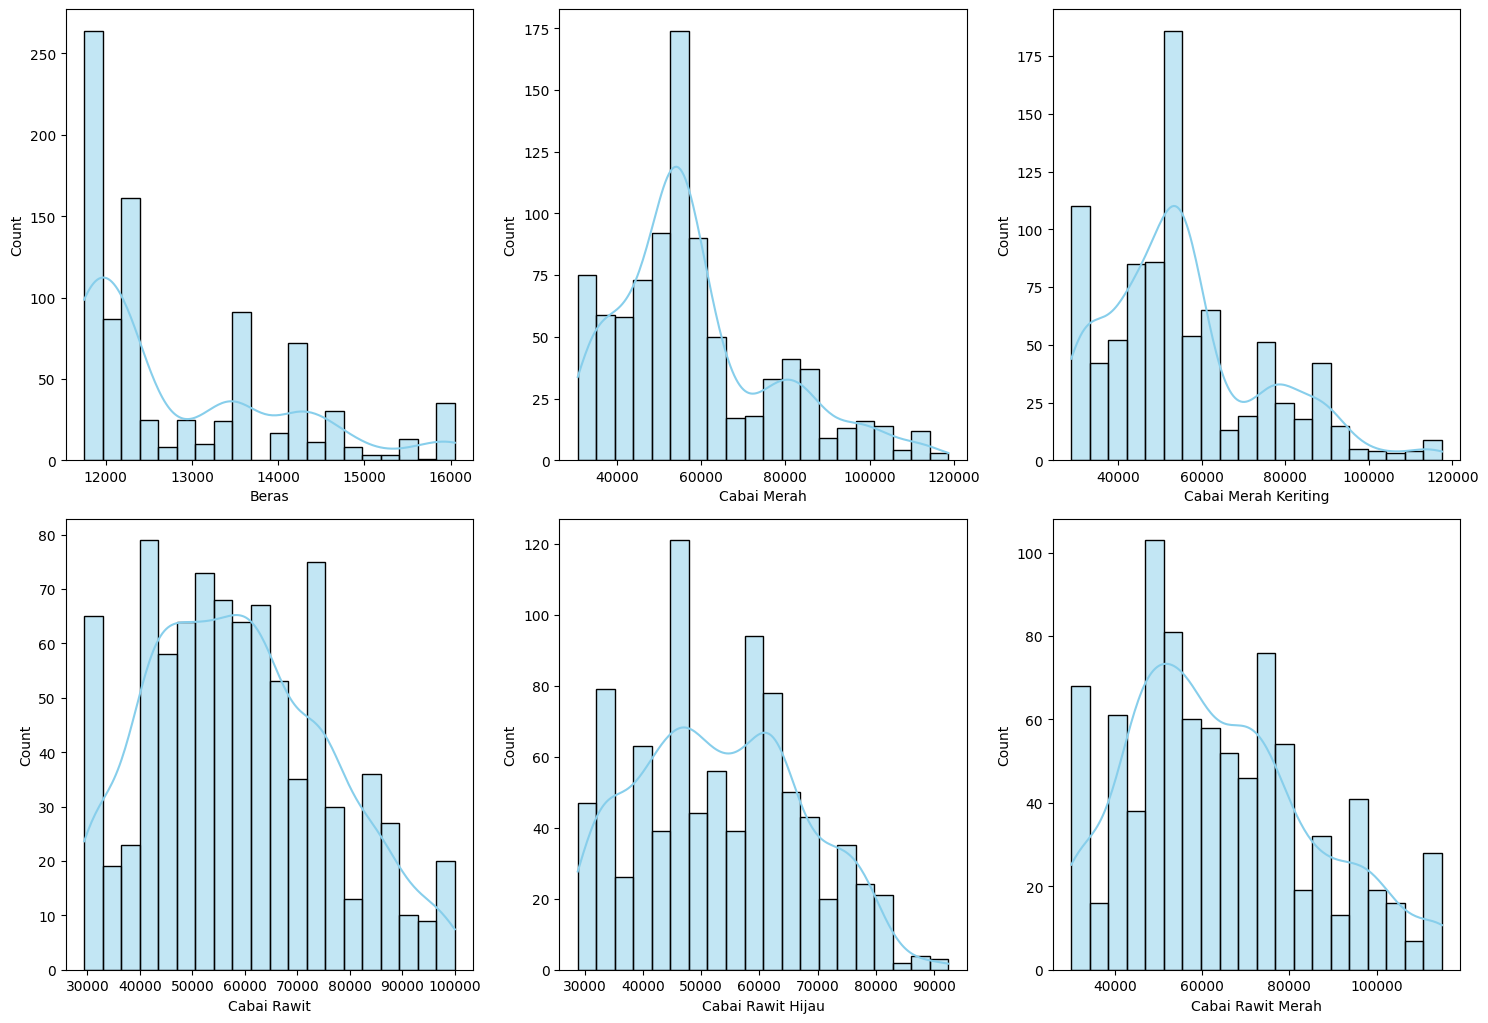

In [17]:
# Set up the subplot grid
plt.figure(figsize=(15, 15))

# Use Seaborn distplot for histograms
for i, column in enumerate(numerical_col, start=1):
    plt.subplot(3, 3, i)
    sns.histplot(df[column], bins=20, kde=True, color='skyblue')
    plt.title('')
    plt.xlabel(column)

plt.tight_layout()

# Show the plots
plt.show()

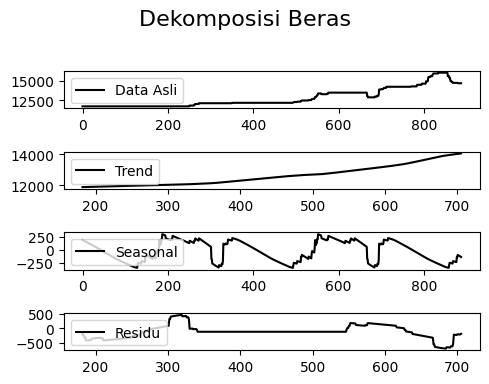

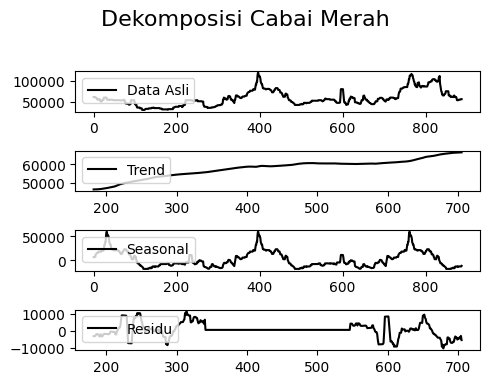

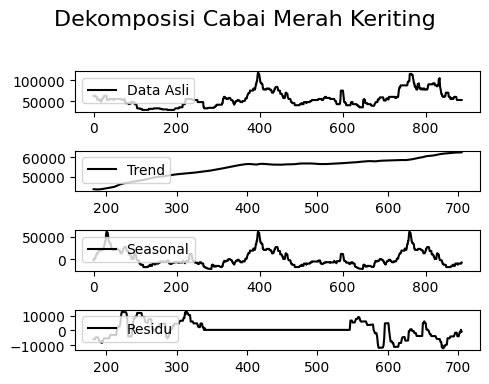

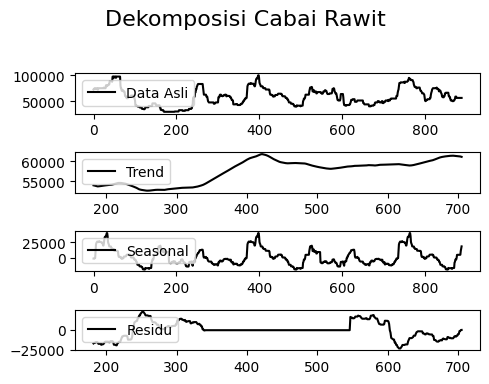

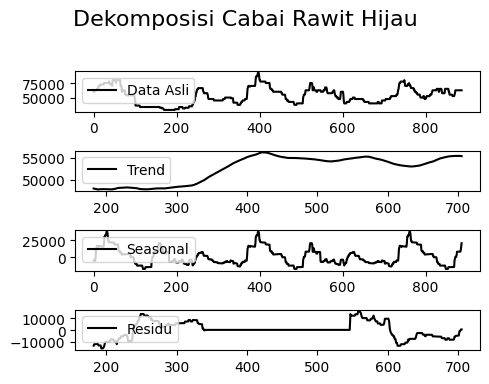

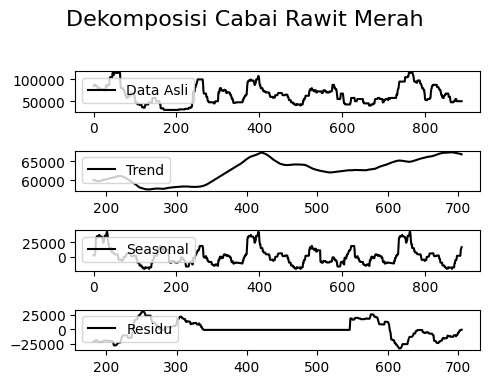

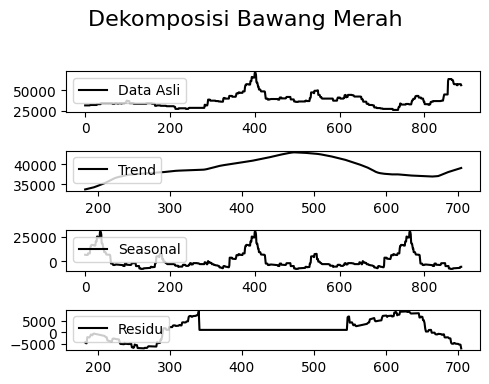

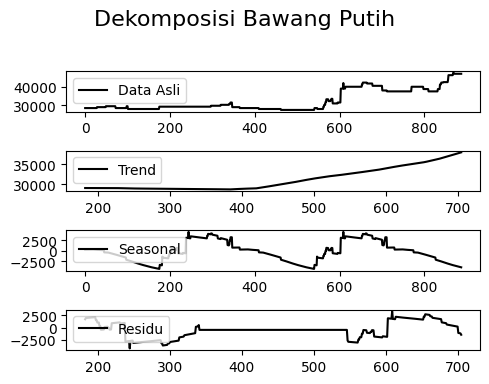

In [18]:


from statsmodels.tsa.seasonal import seasonal_decompose
period = 365

# Buat plot untuk setiap variabel
for variable in ['Beras', 'Cabai Merah', 'Cabai Merah Keriting', 'Cabai Rawit', 'Cabai Rawit Hijau', 'Cabai Rawit Merah', 'Bawang Merah', 'Bawang Putih']:
    # Lakukan dekomposisi
    result = seasonal_decompose(df[variable], model='additive', period=period)

    # Plot hasil dekomposisi
    plt.figure(figsize=(5, 4))
    plt.suptitle(f'Dekomposisi {variable}', fontsize=16)

    plt.subplot(411)
    plt.plot(df.index, df[variable], label='Data Asli', color='black')
    plt.legend(loc='upper left')
    plt.subplot(412)
    plt.plot(df.index, result.trend, label='Trend', color='black')
    plt.legend(loc='upper left')
    plt.subplot(413)
    plt.plot(df.index, result.seasonal, label='Seasonal', color='black')
    plt.legend(loc='upper left')
    plt.subplot(414)
    plt.plot(df.index, result.resid, label='Residu', color='black')
    plt.legend(loc='upper left')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

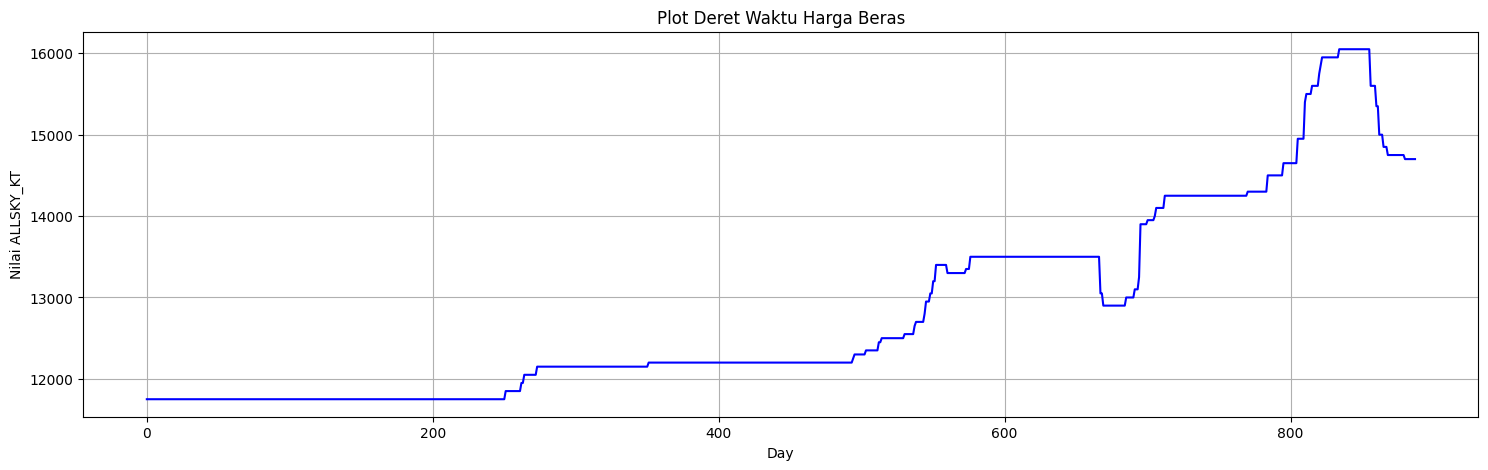

In [19]:
plt.figure(figsize=(18, 5))
plt.plot(df.index, df["Beras"], linestyle='-', color='blue')
plt.title("Plot Deret Waktu Harga Beras")
plt.xlabel("Day")
plt.ylabel("Nilai ALLSKY_KT")
plt.grid()
plt.show()

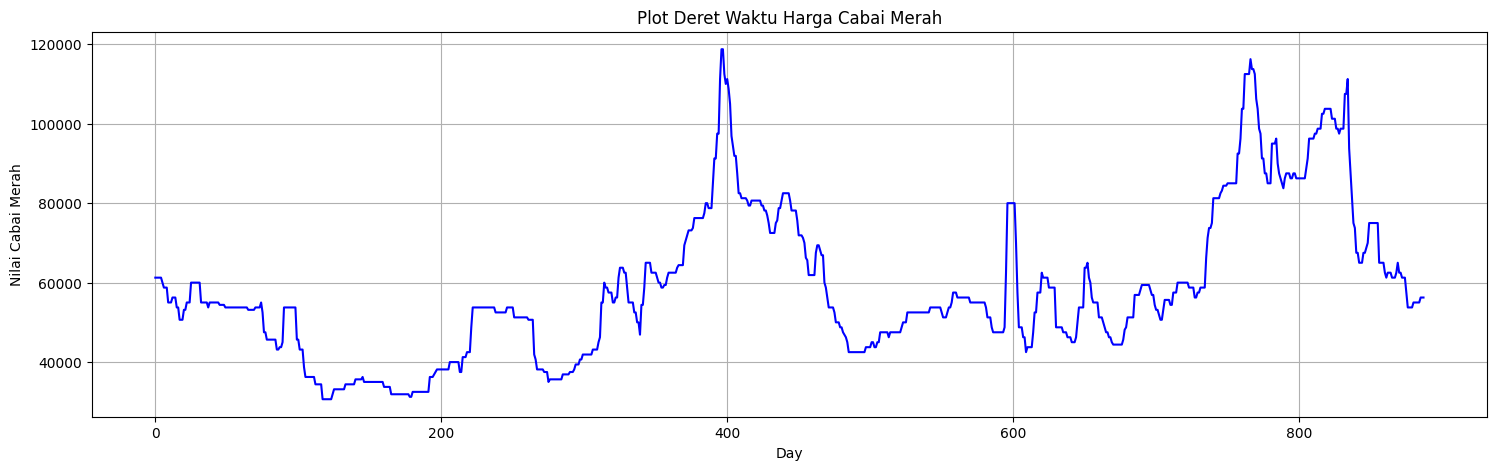

In [20]:
plt.figure(figsize=(18, 5))
plt.plot(df.index, df["Cabai Merah"], linestyle='-', color='blue')
plt.title("Plot Deret Waktu Harga Cabai Merah")
plt.xlabel("Day")
plt.ylabel("Nilai Cabai Merah")
plt.grid()
plt.show()

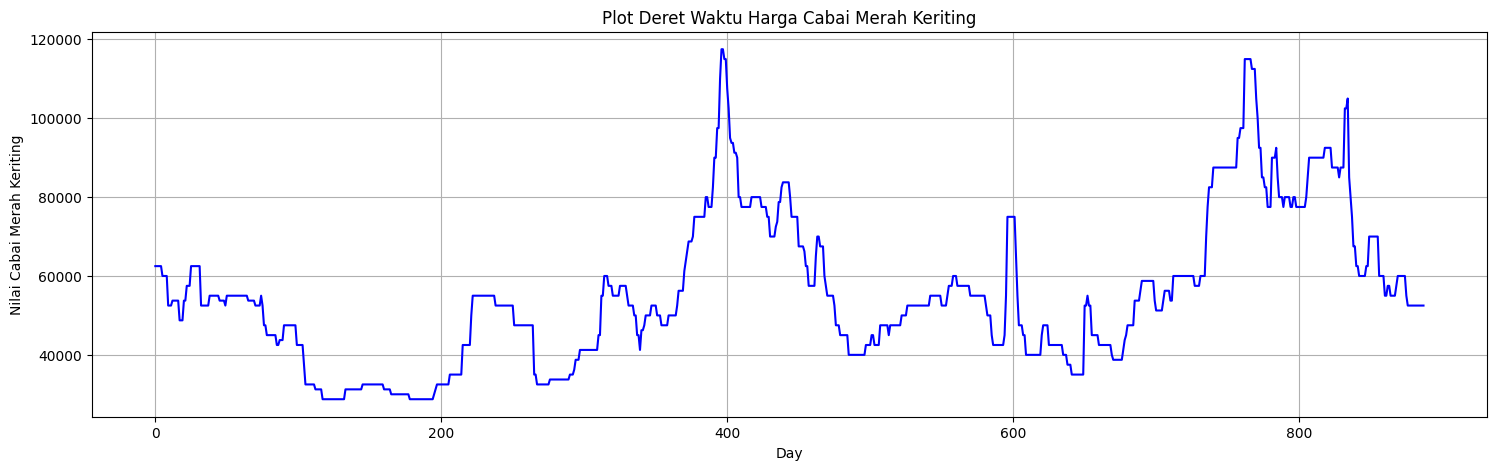

In [21]:
plt.figure(figsize=(18, 5))
plt.plot(df.index, df["Cabai Merah Keriting"], linestyle='-', color='blue')
plt.title("Plot Deret Waktu Harga Cabai Merah Keriting")
plt.xlabel("Day")
plt.ylabel("Nilai Cabai Merah Keriting")
plt.grid()
plt.show()

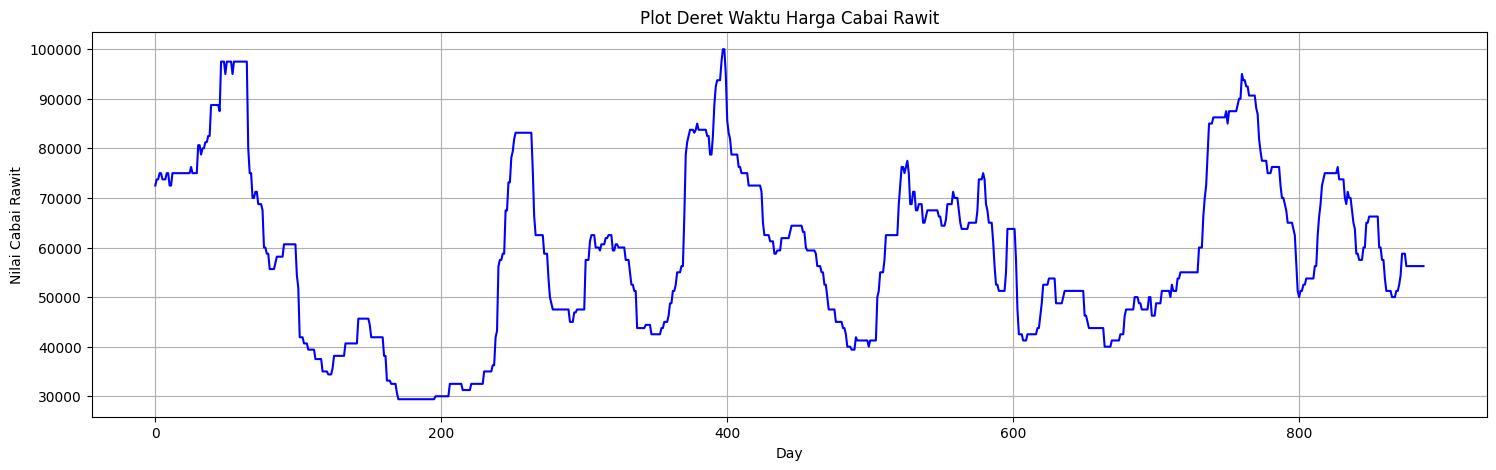

In [22]:
plt.figure(figsize=(18, 5))
plt.plot(df.index, df["Cabai Rawit"], linestyle='-', color='blue')
plt.title("Plot Deret Waktu Harga Cabai Rawit")
plt.xlabel("Day")
plt.ylabel("Nilai Cabai Rawit")
plt.grid()
plt.show()

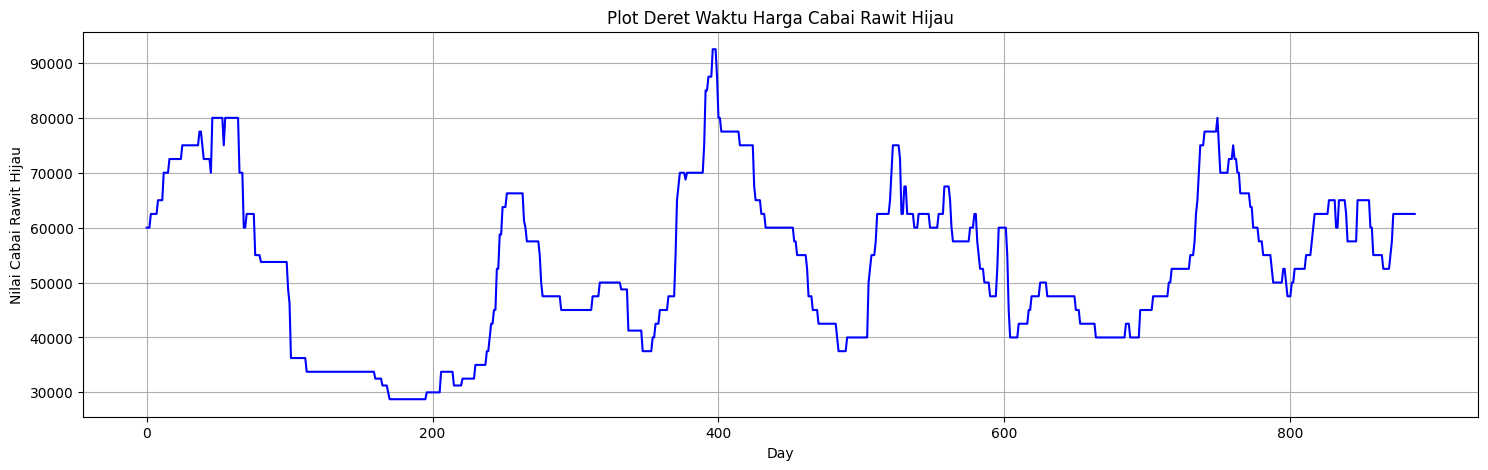

In [23]:
plt.figure(figsize=(18, 5))
plt.plot(df.index, df["Cabai Rawit Hijau"], linestyle='-', color='blue')
plt.title("Plot Deret Waktu Harga Cabai Rawit Hijau")
plt.xlabel("Day")
plt.ylabel("Nilai Cabai Rawit Hijau")
plt.grid()
plt.show()

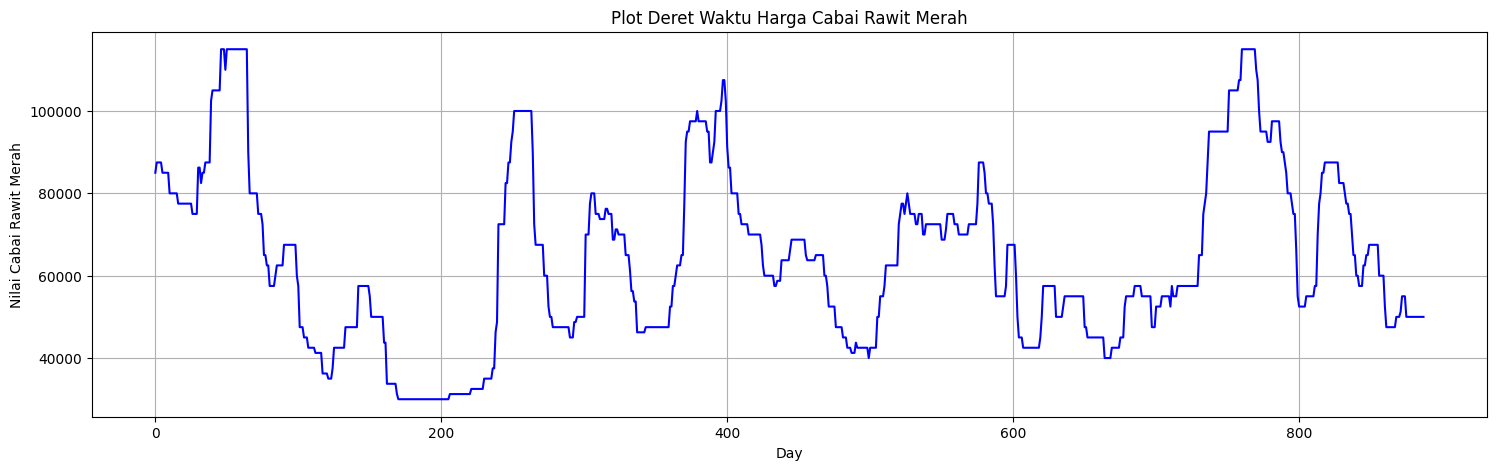

In [24]:
plt.figure(figsize=(18, 5))
plt.plot(df.index, df["Cabai Rawit Merah"], linestyle='-', color='blue')
plt.title("Plot Deret Waktu Harga Cabai Rawit Merah")
plt.xlabel("Day")
plt.ylabel("Nilai Cabai Rawit Merah")
plt.grid()
plt.show()

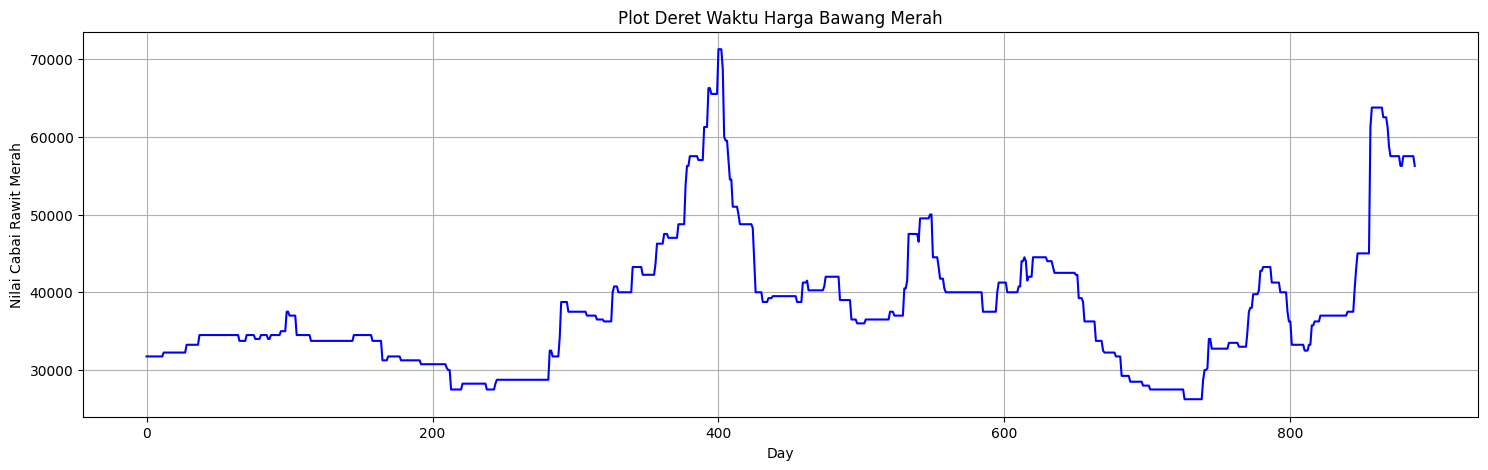

In [25]:
plt.figure(figsize=(18, 5))
plt.plot(df.index, df["Bawang Merah"], linestyle='-', color='blue')
plt.title("Plot Deret Waktu Harga Bawang Merah")
plt.xlabel("Day")
plt.ylabel("Nilai Cabai Rawit Merah")
plt.grid()
plt.show()

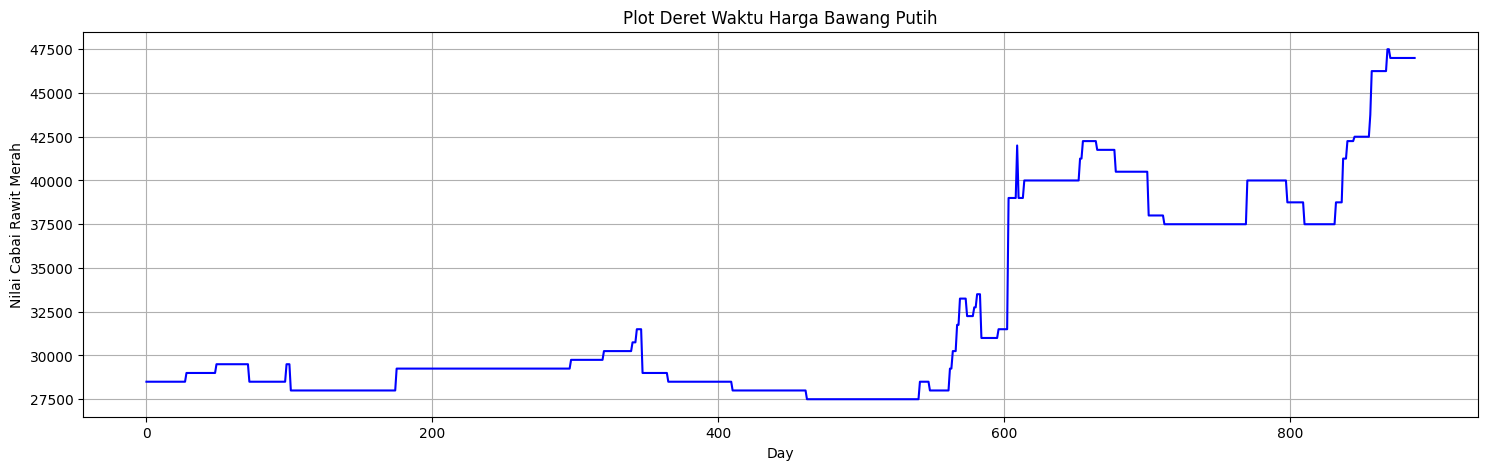

In [26]:
plt.figure(figsize=(18, 5))
plt.plot(df.index, df["Bawang Putih"], linestyle='-', color='blue')
plt.title("Plot Deret Waktu Harga Bawang Putih")
plt.xlabel("Day")
plt.ylabel("Nilai Cabai Rawit Merah")
plt.grid()
plt.show()

In [27]:
df = pd.read_csv('/content/data_clean.csv')
df.head()

,Beras,Cabai Merah,Cabai Merah Keriting,Cabai Rawit,Cabai Rawit Hijau,Cabai Rawit Merah,Bawang Merah,Bawang Putih,Tanggal Lengkap
0,11750.0,61250.0,62500.0,72500.0,60000.0,85000.0,31750.0,28500.0,2021-01-04
1,11750.0,61250.0,62500.0,73750.0,60000.0,87500.0,31750.0,28500.0,2021-01-05
2,11750.0,61250.0,62500.0,73750.0,60000.0,87500.0,31750.0,28500.0,2021-01-06
3,11750.0,61250.0,62500.0,75000.0,62500.0,87500.0,31750.0,28500.0,2021-01-07
4,11750.0,61250.0,62500.0,75000.0,62500.0,87500.0,31750.0,28500.0,2021-01-08


In [28]:
df = df[["Tanggal Lengkap", "Beras"]]
df.head()

,Tanggal Lengkap,Beras
0,2021-01-04,11750.0
1,2021-01-05,11750.0
2,2021-01-06,11750.0
3,2021-01-07,11750.0
4,2021-01-08,11750.0


# MODELLING

<ipython-input-29-de8b1df6635f>:13: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  x_coord = pd.to_datetime("25/9/2023")


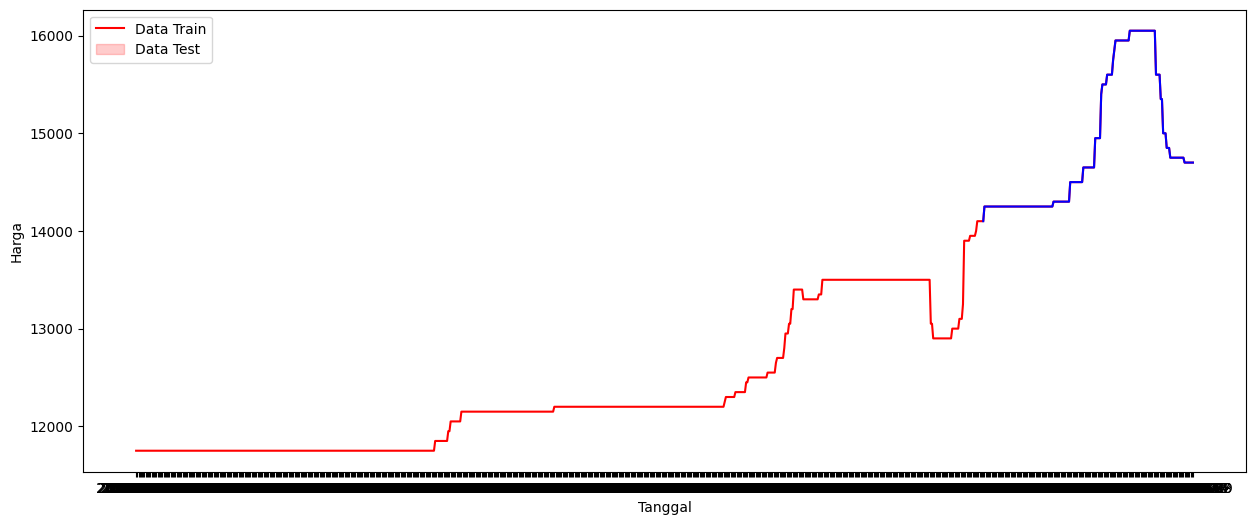

In [29]:
df_train = df
df_test = df.tail(int(0.2 * len(df)))

df.head().style.set_properties(subset=['Tanggal Lengkap'], **{'background-color': 'dodgerblue'})
ax = plt.figure(figsize=(15, 6))
sns.lineplot(x=df['Tanggal Lengkap'], y=df_train['Beras'].fillna(method='ffill'), color='red')
sns.lineplot(x=df['Tanggal Lengkap'], y=df_test['Beras'].fillna(method='ffill'), color='blue')
plt.xlabel('Tanggal')
plt.ylabel('Harga')
plt.legend(labels=['Data Train', 'Data Test'])

# Define the x-coordinate where you want the vertical line
x_coord = pd.to_datetime("25/9/2023")
plt.show()

## FORCAST HARGA BERAS

In [44]:
def get_train_test(file_path, split_percent):
    data = pd.read_csv("data_clean.csv")[["Beras"]]
    data = data.values.reshape(-1, 1)
    train_size = int(len(data) * split_percent)
    train_data, test_data = data[:train_size], data[train_size:]
    return train_data, test_data, data

In [45]:
def get_XY(data, time_steps):
    X, Y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        Y.append(data[i + time_steps, 0])
    return np.array(X).reshape(-1, time_steps, 1), np.array(Y)

In [46]:
def create_LSTM(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(LSTM(hidden_units, activation=activation[0], input_shape=input_shape))
    model.add(Dense(dense_units, activation=activation[1]))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [47]:
def plot_result(trainY, testY, train_predict, test_predict):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.legend(['Data Train', 'Data Test'])
    plt.xlabel('Tanggal')
    plt.ylabel('Harga')

In [48]:
time_steps = 10
hidden_units = 50
dense_units = 1
epochs = 100
batch_size = 32
activation = ['tanh', 'tanh']

In [49]:
file_path = "data_clean.csv"
train_data, test_data, data = get_train_test(file_path, split_percent=0.8)

# Inisialisasi scaler
scaler = MinMaxScaler(feature_range=(0, 1))
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Menyiapkan data pelatihan dan pengujian
trainX, trainY = get_XY(train_data, time_steps)
testX, testY = get_XY(test_data, time_steps)

# Membuat model LSTM
model = create_LSTM(hidden_units=hidden_units, dense_units=dense_units, input_shape=(time_steps,1), activation=activation)

# Melatih model dengan menyimpan history
history = model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=2, validation_data=(testX, testY))

# Prediksi data pelatihan dan pengujian
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# Hitung MAPE
MAPE_train_LSTM = mean_absolute_percentage_error(scaler.inverse_transform(trainY.reshape(-1,1)), scaler.inverse_transform(train_predict))
MAPE_test_LSTM = mean_absolute_percentage_error(scaler.inverse_transform(testY.reshape(-1,1)), scaler.inverse_transform(test_predict.reshape(-1,1)))

# Hitung RMSE
RMSE_train_LSTM = np.sqrt(mean_squared_error(scaler.inverse_transform(trainY.reshape(-1,1)), scaler.inverse_transform(train_predict)))
RMSE_test_LSTM = np.sqrt(mean_squared_error(scaler.inverse_transform(testY.reshape(-1,1)), scaler.inverse_transform(test_predict)))

# Hitung MAE
MAE_train_LSTM = mean_absolute_error(scaler.inverse_transform(trainY.reshape(-1,1)), scaler.inverse_transform(train_predict))
MAE_test_LSTM = mean_absolute_error(scaler.inverse_transform(testY.reshape(-1,1)), scaler.inverse_transform(test_predict))

# Tampilkan MAPE, RMSE, dan MAE
print(f"MAPE_train_LSTM = {round(MAPE_train_LSTM * 100, 2)} %")
print(f"MAPE_test_LSTM = {round(MAPE_test_LSTM * 100, 2)} %")
print(f"RMSE_train_LSTM = {round(RMSE_train_LSTM, 2)}")
print(f"RMSE_test_LSTM = {round(RMSE_test_LSTM, 2)}")
print(f"MAE_train_LSTM = {round(MAE_train_LSTM, 2)}")
print(f"MAE_test_LSTM = {round(MAE_test_LSTM, 2)}")

Epoch 1/100
22/22 - 3s - loss: 0.0441 - val_loss: 0.2497 - 3s/epoch - 121ms/step
Epoch 2/100
22/22 - 0s - loss: 0.0052 - val_loss: 0.2394 - 164ms/epoch - 7ms/step
Epoch 3/100
22/22 - 0s - loss: 0.0016 - val_loss: 0.2214 - 158ms/epoch - 7ms/step
Epoch 4/100
22/22 - 0s - loss: 0.0014 - val_loss: 0.2265 - 162ms/epoch - 7ms/step
Epoch 5/100
22/22 - 0s - loss: 0.0014 - val_loss: 0.2260 - 176ms/epoch - 8ms/step
Epoch 6/100
22/22 - 0s - loss: 0.0015 - val_loss: 0.2223 - 172ms/epoch - 8ms/step
Epoch 7/100
22/22 - 0s - loss: 0.0014 - val_loss: 0.2238 - 163ms/epoch - 7ms/step
Epoch 8/100
22/22 - 0s - loss: 0.0014 - val_loss: 0.2223 - 157ms/epoch - 7ms/step
Epoch 9/100
22/22 - 0s - loss: 0.0014 - val_loss: 0.2254 - 159ms/epoch - 7ms/step
Epoch 10/100
22/22 - 0s - loss: 0.0014 - val_loss: 0.2219 - 164ms/epoch - 7ms/step
Epoch 11/100
22/22 - 0s - loss: 0.0014 - val_loss: 0.2214 - 165ms/epoch - 7ms/step
Epoch 12/100
22/22 - 0s - loss: 0.0013 - val_loss: 0.2188 - 189ms/epoch - 9ms/step
Epoch 13/100
2

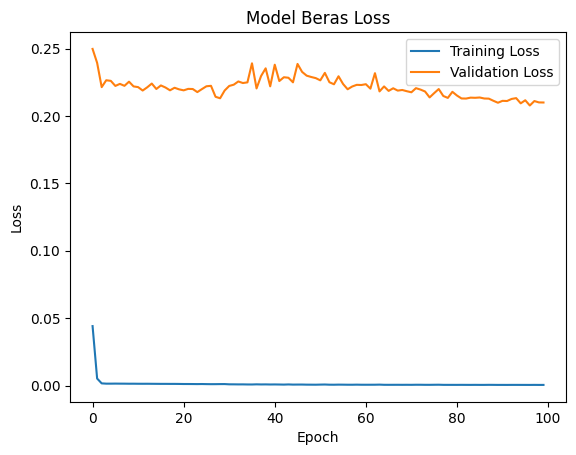

In [50]:
# Visualisasi loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Beras Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

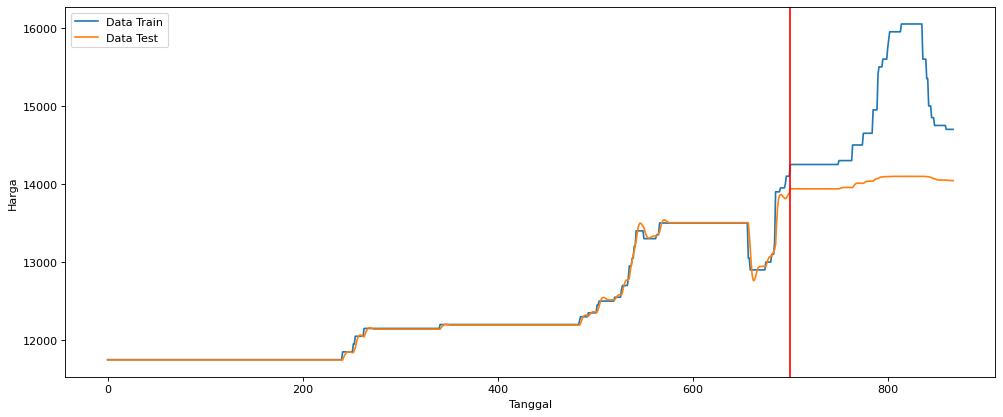

In [51]:
# Plot hasil
plot_result(scaler.inverse_transform(trainY.reshape(-1,1)), scaler.inverse_transform(testY.reshape(-1,1)), scaler.inverse_transform(train_predict.reshape(-1,1)), scaler.inverse_transform(test_predict.reshape(-1,1)))

In [52]:
from joblib import dump, load
# Menyimpan model ke file H5
model.save('model_Beras.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


['scaler_Beras.pkl']

1/1 [==============================] - 0s 23ms/step


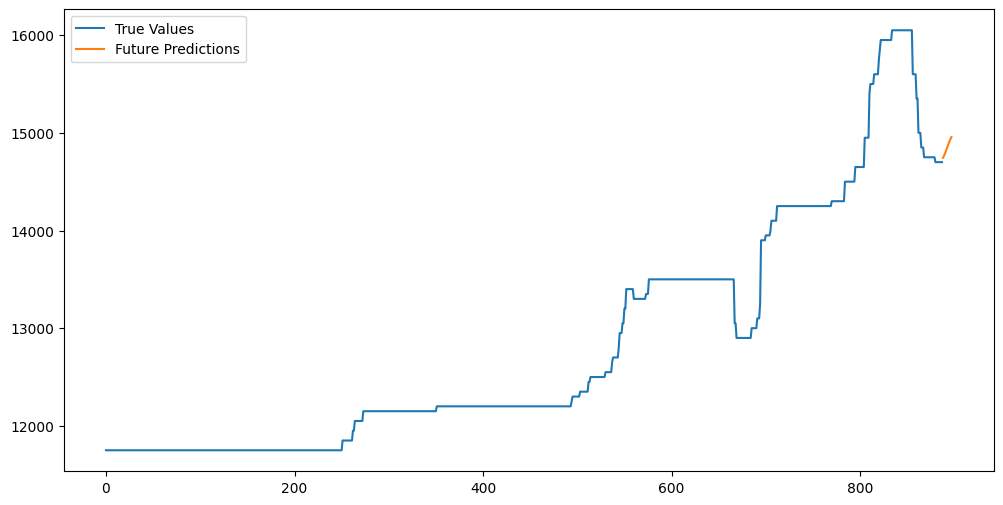

In [55]:
# Memuat model dan scaler
model_Beras = load_model('model_Beras.h5')

target = df['Beras'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler.fit_transform(target)

# Predict future values
future_steps = 10  # Set the number of future steps you want to predict
future_data = scaled_target[-time_steps:, :]

future_predictions = []
for _ in range(future_steps):
    # Reshape the data to match the input shape of the model
    future_input = future_data.reshape((1, time_steps, 1))

    # Make the prediction
    future_pred = model.predict(future_input)

    # Append the prediction to the results
    future_predictions.append(future_pred[0, 0])
    # Update the input data for the next prediction
    future_data = np.vstack((future_data[1:], future_pred))

# Inverse transform the predictions to the original scale
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(target, label='True Values')
plt.plot(np.arange(len(target) , len(target) + future_steps), future_predictions, label='Future Predictions')
plt.legend()
plt.show()

## FORECAST HARGA CABAI MERAH

In [56]:
def get_train_test(file_path, split_percent):
    data = pd.read_csv("data_clean.csv")[["Cabai Merah"]]
    data = data.values.reshape(-1, 1)
    train_size = int(len(data) * split_percent)
    train_data, test_data = data[:train_size], data[train_size:]
    return train_data, test_data, data
def get_XY(data, time_steps):
    X, Y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        Y.append(data[i + time_steps, 0])
    return np.array(X).reshape(-1, time_steps, 1), np.array(Y)
def create_LSTM(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(LSTM(hidden_units, activation=activation[0], input_shape=input_shape))
    model.add(Dense(dense_units, activation=activation[1]))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model
def plot_result(trainY, testY, train_predict, test_predict):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.legend(['Data Train', 'Data Test'])
    plt.xlabel('Tanggal')
    plt.ylabel('Harga')

In [57]:
time_steps = 10
hidden_units = 50
dense_units = 1
epochs = 100
batch_size = 32
activation = ['tanh', 'tanh']
file_path = "data_clean.csv"
train_data, test_data, data = get_train_test(file_path, split_percent=0.8)

# Inisialisasi scaler
scaler = MinMaxScaler(feature_range=(0, 1))
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Menyiapkan data pelatihan dan pengujian
trainX, trainY = get_XY(train_data, time_steps)
testX, testY = get_XY(test_data, time_steps)

# Membuat model LSTM
model = create_LSTM(hidden_units=hidden_units, dense_units=dense_units, input_shape=(time_steps,1), activation=activation)

# Melatih model dengan menyimpan history
history = model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=2, validation_data=(testX, testY))

# Prediksi data pelatihan dan pengujian
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# Hitung MAPE
MAPE_train_LSTM = mean_absolute_percentage_error(scaler.inverse_transform(trainY.reshape(-1,1)), scaler.inverse_transform(train_predict))
MAPE_test_LSTM = mean_absolute_percentage_error(scaler.inverse_transform(testY.reshape(-1,1)), scaler.inverse_transform(test_predict.reshape(-1,1)))

# Hitung RMSE
RMSE_train_LSTM = np.sqrt(mean_squared_error(scaler.inverse_transform(trainY.reshape(-1,1)), scaler.inverse_transform(train_predict)))
RMSE_test_LSTM = np.sqrt(mean_squared_error(scaler.inverse_transform(testY.reshape(-1,1)), scaler.inverse_transform(test_predict)))

# Hitung MAE
MAE_train_LSTM = mean_absolute_error(scaler.inverse_transform(trainY.reshape(-1,1)), scaler.inverse_transform(train_predict))
MAE_test_LSTM = mean_absolute_error(scaler.inverse_transform(testY.reshape(-1,1)), scaler.inverse_transform(test_predict))

# Tampilkan MAPE, RMSE, dan MAE
print(f"MAPE_train_LSTM = {round(MAPE_train_LSTM * 100, 2)} %")
print(f"MAPE_test_LSTM = {round(MAPE_test_LSTM * 100, 2)} %")
print(f"RMSE_train_LSTM = {round(RMSE_train_LSTM, 2)}")
print(f"RMSE_test_LSTM = {round(RMSE_test_LSTM, 2)}")
print(f"MAE_train_LSTM = {round(MAE_train_LSTM, 2)}")
print(f"MAE_test_LSTM = {round(MAE_test_LSTM, 2)}")

Epoch 1/100
22/22 - 4s - loss: 0.0360 - val_loss: 0.0158 - 4s/epoch - 172ms/step
Epoch 2/100
22/22 - 0s - loss: 0.0090 - val_loss: 0.0271 - 168ms/epoch - 8ms/step
Epoch 3/100
22/22 - 0s - loss: 0.0051 - val_loss: 0.0114 - 174ms/epoch - 8ms/step
Epoch 4/100
22/22 - 0s - loss: 0.0040 - val_loss: 0.0090 - 165ms/epoch - 7ms/step
Epoch 5/100
22/22 - 0s - loss: 0.0039 - val_loss: 0.0093 - 165ms/epoch - 8ms/step
Epoch 6/100
22/22 - 0s - loss: 0.0037 - val_loss: 0.0079 - 162ms/epoch - 7ms/step
Epoch 7/100
22/22 - 0s - loss: 0.0035 - val_loss: 0.0073 - 169ms/epoch - 8ms/step
Epoch 8/100
22/22 - 0s - loss: 0.0034 - val_loss: 0.0073 - 166ms/epoch - 8ms/step
Epoch 9/100
22/22 - 0s - loss: 0.0032 - val_loss: 0.0073 - 172ms/epoch - 8ms/step
Epoch 10/100
22/22 - 0s - loss: 0.0031 - val_loss: 0.0070 - 149ms/epoch - 7ms/step
Epoch 11/100
22/22 - 0s - loss: 0.0028 - val_loss: 0.0061 - 162ms/epoch - 7ms/step
Epoch 12/100
22/22 - 0s - loss: 0.0027 - val_loss: 0.0055 - 171ms/epoch - 8ms/step
Epoch 13/100
2

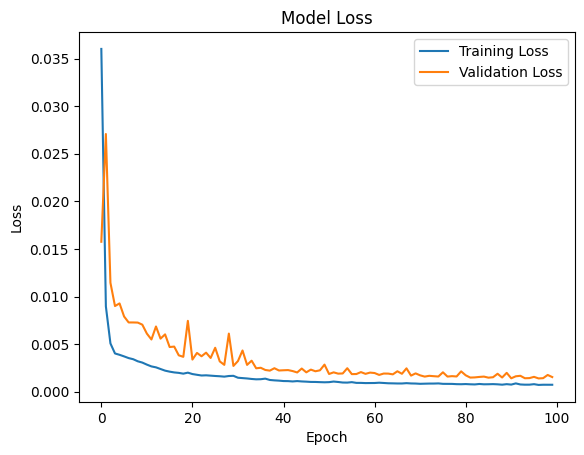

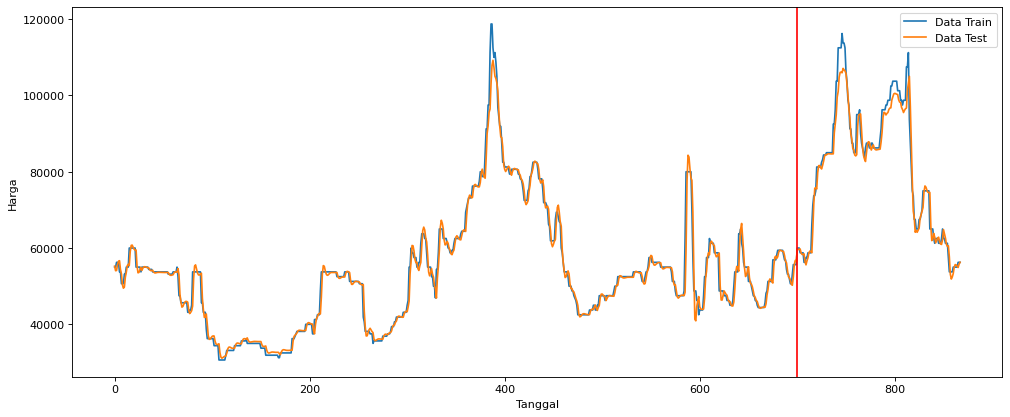

In [58]:
# Visualisasi loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()
# Plot hasil
plot_result(scaler.inverse_transform(trainY.reshape(-1,1)), scaler.inverse_transform(testY.reshape(-1,1)), scaler.inverse_transform(train_predict.reshape(-1,1)), scaler.inverse_transform(test_predict.reshape(-1,1)))

In [59]:
from joblib import dump, load
# Menyimpan model ke file H5
model.save('model_Cabai Merah.h5')
# Menyimpan scaler
#dump(scaler,'scaler_Cabai Merah.pkl')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 21ms/step


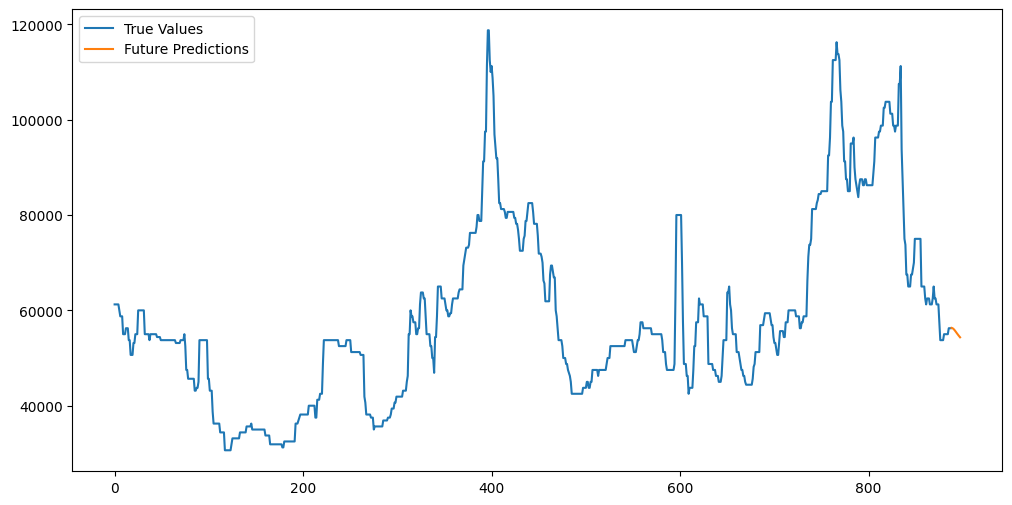

In [60]:
from keras.models import load_model
model_CabaiMerah = load_model('model_Cabai Merah.h5')

target = df['Cabai Merah'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler.fit_transform(target)

# Predict future values
future_steps = 10  # Set the number of future steps you want to predict
future_data = scaled_target[-time_steps:, :]

future_predictions = []
for _ in range(future_steps):
    # Reshape the data to match the input shape of the model
    future_input = future_data.reshape((1, time_steps, 1))

    # Make the prediction
    future_pred = model_CabaiMerah.predict(future_input)

    # Append the prediction to the results
    future_predictions.append(future_pred[0, 0])
    # Update the input data for the next prediction
    future_data = np.vstack((future_data[1:], future_pred))

# Inverse transform the predictions to the original scale
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(target, label='True Values')
plt.plot(np.arange(len(target) , len(target) + future_steps), future_predictions, label='Future Predictions')
plt.legend()
plt.show()

## FORCAST HARGA BERAS CABAI MERAH KERITING

In [ ]:
def get_train_test(file_path, split_percent):
    data = pd.read_csv("data_clean.csv")[["Cabai Merah Keriting"]]
    data = data.values.reshape(-1, 1)
    train_size = int(len(data) * split_percent)
    train_data, test_data = data[:train_size], data[train_size:]
    return train_data, test_data, data
def get_XY(data, time_steps):
    X, Y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        Y.append(data[i + time_steps, 0])
    return np.array(X).reshape(-1, time_steps, 1), np.array(Y)
def create_LSTM(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(LSTM(hidden_units, activation=activation[0], input_shape=input_shape))
    model.add(Dense(dense_units, activation=activation[1]))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model
def plot_result(trainY, testY, train_predict, test_predict):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.legend(['Data Train', 'Data Test'])
    plt.xlabel('Tanggal')
    plt.ylabel('Harga')

In [61]:
time_steps = 10
hidden_units = 50
dense_units = 1
epochs = 100
batch_size = 32
activation = ['tanh', 'tanh']
file_path = "data_clean.csv"
train_data, test_data, data = get_train_test(file_path, split_percent=0.8)

# Inisialisasi scaler
scaler = MinMaxScaler(feature_range=(0, 1))
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Menyiapkan data pelatihan dan pengujian
trainX, trainY = get_XY(train_data, time_steps)
testX, testY = get_XY(test_data, time_steps)

# Membuat model LSTM
model = create_LSTM(hidden_units=hidden_units, dense_units=dense_units, input_shape=(time_steps,1), activation=activation)

# Melatih model dengan menyimpan history
history = model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=2, validation_data=(testX, testY))

# Prediksi data pelatihan dan pengujian
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# Hitung MAPE
MAPE_train_LSTM = mean_absolute_percentage_error(scaler.inverse_transform(trainY.reshape(-1,1)), scaler.inverse_transform(train_predict))
MAPE_test_LSTM = mean_absolute_percentage_error(scaler.inverse_transform(testY.reshape(-1,1)), scaler.inverse_transform(test_predict.reshape(-1,1)))

# Hitung RMSE
RMSE_train_LSTM = np.sqrt(mean_squared_error(scaler.inverse_transform(trainY.reshape(-1,1)), scaler.inverse_transform(train_predict)))
RMSE_test_LSTM = np.sqrt(mean_squared_error(scaler.inverse_transform(testY.reshape(-1,1)), scaler.inverse_transform(test_predict)))

# Hitung MAE
MAE_train_LSTM = mean_absolute_error(scaler.inverse_transform(trainY.reshape(-1,1)), scaler.inverse_transform(train_predict))
MAE_test_LSTM = mean_absolute_error(scaler.inverse_transform(testY.reshape(-1,1)), scaler.inverse_transform(test_predict))

# Tampilkan MAPE, RMSE, dan MAE
print(f"MAPE_train_LSTM = {round(MAPE_train_LSTM * 100, 2)} %")
print(f"MAPE_test_LSTM = {round(MAPE_test_LSTM * 100, 2)} %")
print(f"RMSE_train_LSTM = {round(RMSE_train_LSTM, 2)}")
print(f"RMSE_test_LSTM = {round(RMSE_test_LSTM, 2)}")
print(f"MAE_train_LSTM = {round(MAE_train_LSTM, 2)}")
print(f"MAE_test_LSTM = {round(MAE_test_LSTM, 2)}")

Epoch 1/100
22/22 - 3s - loss: 0.0328 - val_loss: 0.0144 - 3s/epoch - 120ms/step
Epoch 2/100
22/22 - 0s - loss: 0.0082 - val_loss: 0.0239 - 158ms/epoch - 7ms/step
Epoch 3/100
22/22 - 0s - loss: 0.0051 - val_loss: 0.0118 - 159ms/epoch - 7ms/step
Epoch 4/100
22/22 - 0s - loss: 0.0042 - val_loss: 0.0086 - 163ms/epoch - 7ms/step
Epoch 5/100
22/22 - 0s - loss: 0.0040 - val_loss: 0.0085 - 165ms/epoch - 7ms/step
Epoch 6/100
22/22 - 0s - loss: 0.0038 - val_loss: 0.0080 - 167ms/epoch - 8ms/step
Epoch 7/100
22/22 - 0s - loss: 0.0037 - val_loss: 0.0084 - 177ms/epoch - 8ms/step
Epoch 8/100
22/22 - 0s - loss: 0.0036 - val_loss: 0.0083 - 164ms/epoch - 7ms/step
Epoch 9/100
22/22 - 0s - loss: 0.0035 - val_loss: 0.0089 - 160ms/epoch - 7ms/step
Epoch 10/100
22/22 - 0s - loss: 0.0034 - val_loss: 0.0079 - 163ms/epoch - 7ms/step
Epoch 11/100
22/22 - 0s - loss: 0.0031 - val_loss: 0.0069 - 160ms/epoch - 7ms/step
Epoch 12/100
22/22 - 0s - loss: 0.0030 - val_loss: 0.0065 - 169ms/epoch - 8ms/step
Epoch 13/100
2

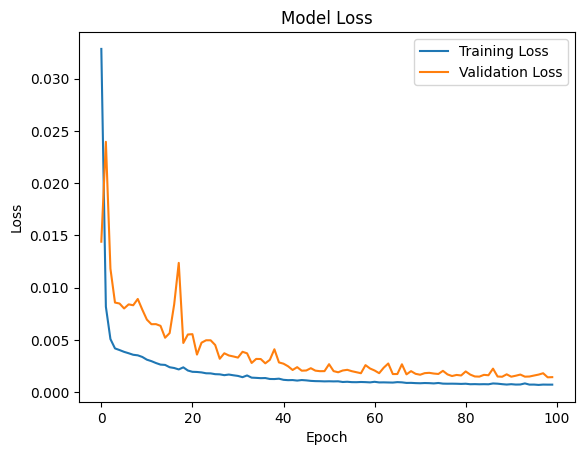

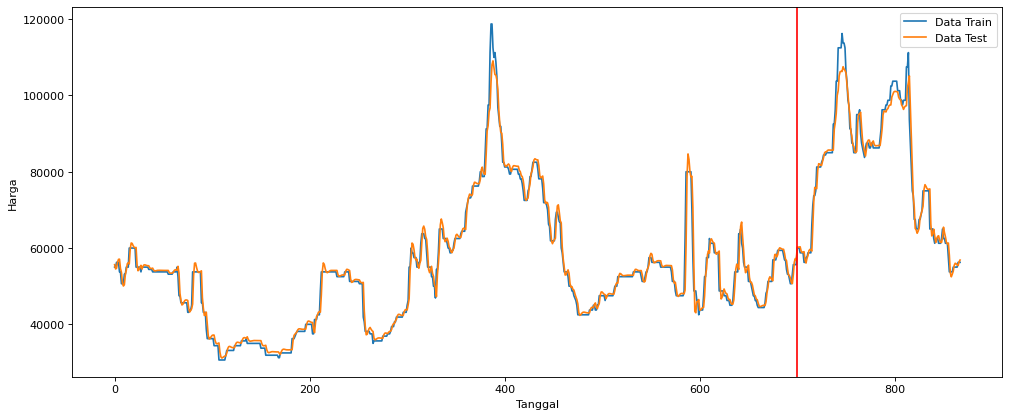

In [62]:
# Visualisasi loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()
# Plot hasil
plot_result(scaler.inverse_transform(trainY.reshape(-1,1)), scaler.inverse_transform(testY.reshape(-1,1)), scaler.inverse_transform(train_predict.reshape(-1,1)), scaler.inverse_transform(test_predict.reshape(-1,1)))

In [63]:
from joblib import dump, load
# Menyimpan model ke file H5
model.save('model_Cabai_Merah_Keriting.h5')
# Menyimpan scaler
#dump(scaler, 'scaler_Beras.pkl')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 22ms/step


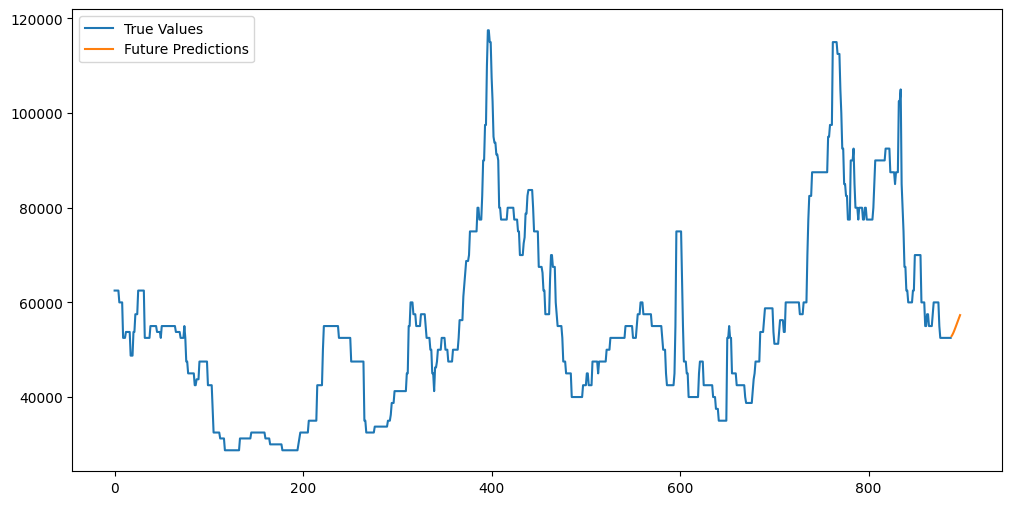

In [64]:
from keras.models import load_model
model_Cabai_Merah_Keriting = load_model('model_Cabai_Merah_Keriting.h5')

target = df['Cabai Merah Keriting'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler.fit_transform(target)

# Predict future values
future_steps = 10  # Set the number of future steps you want to predict
future_data = scaled_target[-time_steps:, :]

future_predictions = []
for _ in range(future_steps):
    # Reshape the data to match the input shape of the model
    future_input = future_data.reshape((1, time_steps, 1))

    # Make the prediction
    future_pred = model_Cabai_Merah_Keriting.predict(future_input)

    # Append the prediction to the results
    future_predictions.append(future_pred[0, 0])
    # Update the input data for the next prediction
    future_data = np.vstack((future_data[1:], future_pred))

# Inverse transform the predictions to the original scale
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(target, label='True Values')
plt.plot(np.arange(len(target) , len(target) + future_steps), future_predictions, label='Future Predictions')
plt.legend()
plt.show()

## FORCAST HARGA CABAI RAWIT

In [65]:
def get_train_test(file_path, split_percent):
    data = pd.read_csv("data_clean.csv")[["Cabai Rawit"]]
    data = data.values.reshape(-1, 1)
    train_size = int(len(data) * split_percent)
    train_data, test_data = data[:train_size], data[train_size:]
    return train_data, test_data, data
def get_XY(data, time_steps):
    X, Y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        Y.append(data[i + time_steps, 0])
    return np.array(X).reshape(-1, time_steps, 1), np.array(Y)
def create_LSTM(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(LSTM(hidden_units, activation=activation[0], input_shape=input_shape))
    model.add(Dense(dense_units, activation=activation[1]))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model
def plot_result(trainY, testY, train_predict, test_predict):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.legend(['Data Train', 'Data Test'])
    plt.xlabel('Tanggal')
    plt.ylabel('Harga')

In [66]:
time_steps = 10
hidden_units = 50
dense_units = 1
epochs = 100
batch_size = 32
activation = ['tanh', 'tanh']
file_path = "data_clean.csv"
train_data, test_data, data = get_train_test(file_path, split_percent=0.8)

# Inisialisasi scaler
scaler = MinMaxScaler(feature_range=(0, 1))
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Menyiapkan data pelatihan dan pengujian
trainX, trainY = get_XY(train_data, time_steps)
testX, testY = get_XY(test_data, time_steps)

# Membuat model LSTM
model = create_LSTM(hidden_units=hidden_units, dense_units=dense_units, input_shape=(time_steps,1), activation=activation)

# Melatih model dengan menyimpan history
history = model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=2, validation_data=(testX, testY))

# Prediksi data pelatihan dan pengujian
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# Hitung MAPE
MAPE_train_LSTM = mean_absolute_percentage_error(scaler.inverse_transform(trainY.reshape(-1,1)), scaler.inverse_transform(train_predict))
MAPE_test_LSTM = mean_absolute_percentage_error(scaler.inverse_transform(testY.reshape(-1,1)), scaler.inverse_transform(test_predict.reshape(-1,1)))

# Hitung RMSE
RMSE_train_LSTM = np.sqrt(mean_squared_error(scaler.inverse_transform(trainY.reshape(-1,1)), scaler.inverse_transform(train_predict)))
RMSE_test_LSTM = np.sqrt(mean_squared_error(scaler.inverse_transform(testY.reshape(-1,1)), scaler.inverse_transform(test_predict)))

# Hitung MAE
MAE_train_LSTM = mean_absolute_error(scaler.inverse_transform(trainY.reshape(-1,1)), scaler.inverse_transform(train_predict))
MAE_test_LSTM = mean_absolute_error(scaler.inverse_transform(testY.reshape(-1,1)), scaler.inverse_transform(test_predict))

# Tampilkan MAPE, RMSE, dan MAE
print(f"MAPE_train_LSTM = {round(MAPE_train_LSTM * 100, 2)} %")
print(f"MAPE_test_LSTM = {round(MAPE_test_LSTM * 100, 2)} %")
print(f"RMSE_train_LSTM = {round(RMSE_train_LSTM, 2)}")
print(f"RMSE_test_LSTM = {round(RMSE_test_LSTM, 2)}")
print(f"MAE_train_LSTM = {round(MAE_train_LSTM, 2)}")
print(f"MAE_test_LSTM = {round(MAE_test_LSTM, 2)}")

Epoch 1/100
22/22 - 4s - loss: 0.0558 - val_loss: 0.0134 - 4s/epoch - 180ms/step
Epoch 2/100
22/22 - 0s - loss: 0.0132 - val_loss: 0.0139 - 169ms/epoch - 8ms/step
Epoch 3/100
22/22 - 0s - loss: 0.0084 - val_loss: 0.0083 - 187ms/epoch - 8ms/step
Epoch 4/100
22/22 - 0s - loss: 0.0074 - val_loss: 0.0079 - 175ms/epoch - 8ms/step
Epoch 5/100
22/22 - 0s - loss: 0.0069 - val_loss: 0.0077 - 186ms/epoch - 8ms/step
Epoch 6/100
22/22 - 0s - loss: 0.0067 - val_loss: 0.0076 - 182ms/epoch - 8ms/step
Epoch 7/100
22/22 - 0s - loss: 0.0064 - val_loss: 0.0072 - 191ms/epoch - 9ms/step
Epoch 8/100
22/22 - 0s - loss: 0.0061 - val_loss: 0.0067 - 182ms/epoch - 8ms/step
Epoch 9/100
22/22 - 0s - loss: 0.0058 - val_loss: 0.0067 - 163ms/epoch - 7ms/step
Epoch 10/100
22/22 - 0s - loss: 0.0055 - val_loss: 0.0062 - 166ms/epoch - 8ms/step
Epoch 11/100
22/22 - 0s - loss: 0.0052 - val_loss: 0.0056 - 168ms/epoch - 8ms/step
Epoch 12/100
22/22 - 0s - loss: 0.0049 - val_loss: 0.0051 - 177ms/epoch - 8ms/step
Epoch 13/100
2

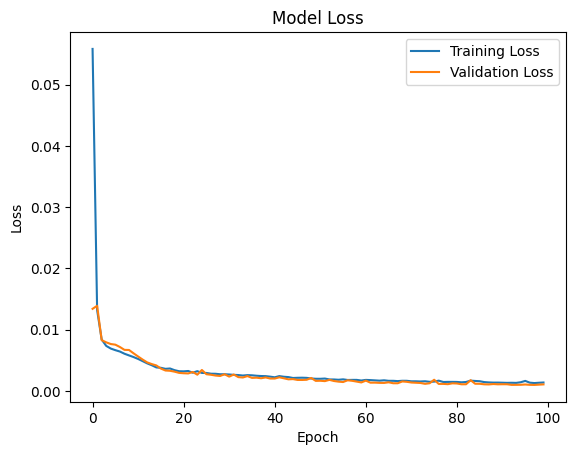

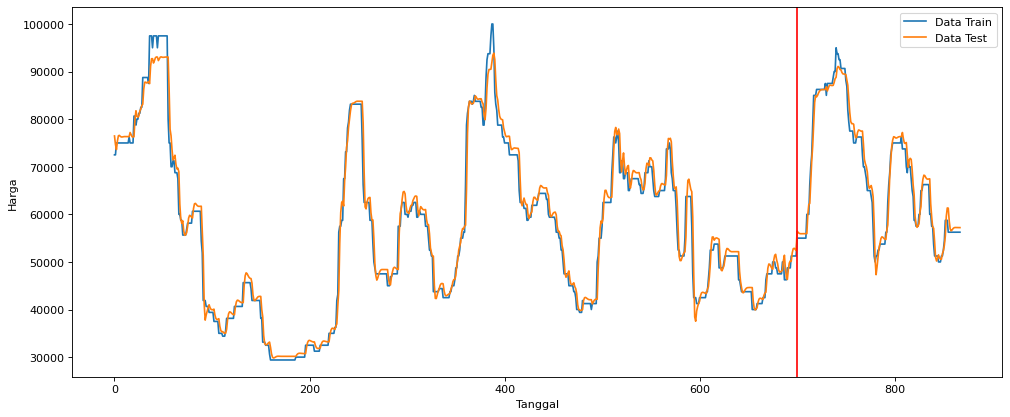

In [67]:
# Visualisasi loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()
# Plot hasil
plot_result(scaler.inverse_transform(trainY.reshape(-1,1)), scaler.inverse_transform(testY.reshape(-1,1)), scaler.inverse_transform(train_predict.reshape(-1,1)), scaler.inverse_transform(test_predict.reshape(-1,1)))

In [68]:
from joblib import dump, load
# Menyimpan model ke file H5
model.save('model_Cabai_Rawit.h5')
# Menyimpan scaler
#dump(scaler, 'scaler_Beras.pkl')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 28ms/step


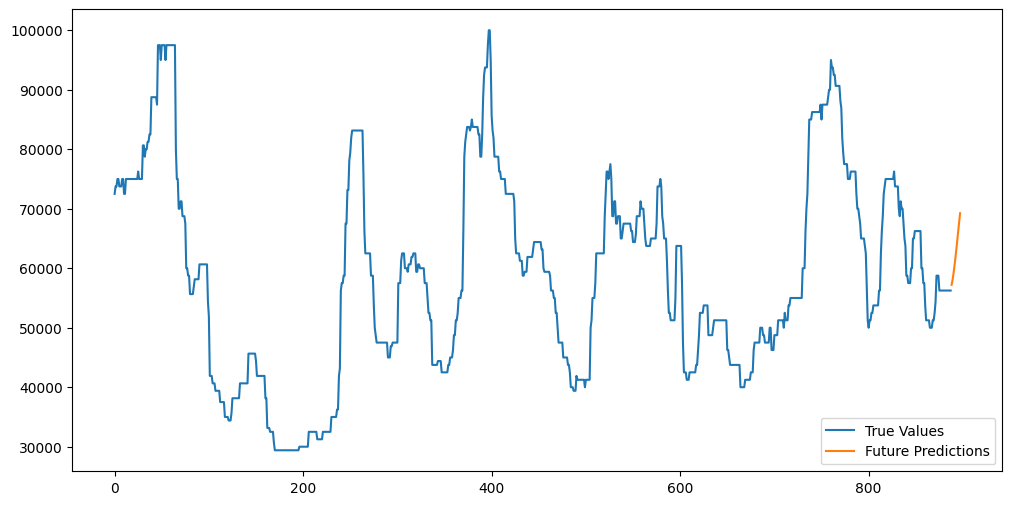

In [70]:
from keras.models import load_model
model_Cabai_Rawit = load_model('model_Cabai_Rawit.h5')

target = df['Cabai Rawit'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler.fit_transform(target)

# Predict future values
future_steps = 10  # Set the number of future steps you want to predict
future_data = scaled_target[-time_steps:, :]

future_predictions = []
for _ in range(future_steps):
    # Reshape the data to match the input shape of the model
    future_input = future_data.reshape((1, time_steps, 1))

    # Make the prediction
    future_pred = model_Cabai_Rawit.predict(future_input)

    # Append the prediction to the results
    future_predictions.append(future_pred[0, 0])
    # Update the input data for the next prediction
    future_data = np.vstack((future_data[1:], future_pred))

# Inverse transform the predictions to the original scale
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(target, label='True Values')
plt.plot(np.arange(len(target) , len(target) + future_steps), future_predictions, label='Future Predictions')
plt.legend()
plt.show()

## FORCAST HARGA CABAI RAWIT HIJAU

In [71]:
def get_train_test(file_path, split_percent):
    data = pd.read_csv("data_clean.csv")[["Cabai Rawit Hijau"]]
    data = data.values.reshape(-1, 1)
    train_size = int(len(data) * split_percent)
    train_data, test_data = data[:train_size], data[train_size:]
    return train_data, test_data, data
def get_XY(data, time_steps):
    X, Y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        Y.append(data[i + time_steps, 0])
    return np.array(X).reshape(-1, time_steps, 1), np.array(Y)
def create_LSTM(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(LSTM(hidden_units, activation=activation[0], input_shape=input_shape))
    model.add(Dense(dense_units, activation=activation[1]))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model
def plot_result(trainY, testY, train_predict, test_predict):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.legend(['Data Train', 'Data Test'])
    plt.xlabel('Tanggal')
    plt.ylabel('Harga')

In [72]:
time_steps = 10
hidden_units = 50
dense_units = 1
epochs = 100
batch_size = 32
activation = ['tanh', 'tanh']
file_path = "data_clean.csv"
train_data, test_data, data = get_train_test(file_path, split_percent=0.8)

# Inisialisasi scaler
scaler = MinMaxScaler(feature_range=(0, 1))
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Menyiapkan data pelatihan dan pengujian
trainX, trainY = get_XY(train_data, time_steps)
testX, testY = get_XY(test_data, time_steps)

# Membuat model LSTM
model = create_LSTM(hidden_units=hidden_units, dense_units=dense_units, input_shape=(time_steps,1), activation=activation)

# Melatih model dengan menyimpan history
history = model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=2, validation_data=(testX, testY))

# Prediksi data pelatihan dan pengujian
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# Hitung MAPE
MAPE_train_LSTM = mean_absolute_percentage_error(scaler.inverse_transform(trainY.reshape(-1,1)), scaler.inverse_transform(train_predict))
MAPE_test_LSTM = mean_absolute_percentage_error(scaler.inverse_transform(testY.reshape(-1,1)), scaler.inverse_transform(test_predict.reshape(-1,1)))

# Hitung RMSE
RMSE_train_LSTM = np.sqrt(mean_squared_error(scaler.inverse_transform(trainY.reshape(-1,1)), scaler.inverse_transform(train_predict)))
RMSE_test_LSTM = np.sqrt(mean_squared_error(scaler.inverse_transform(testY.reshape(-1,1)), scaler.inverse_transform(test_predict)))

# Hitung MAE
MAE_train_LSTM = mean_absolute_error(scaler.inverse_transform(trainY.reshape(-1,1)), scaler.inverse_transform(train_predict))
MAE_test_LSTM = mean_absolute_error(scaler.inverse_transform(testY.reshape(-1,1)), scaler.inverse_transform(test_predict))

# Tampilkan MAPE, RMSE, dan MAE
print(f"MAPE_train_LSTM = {round(MAPE_train_LSTM * 100, 2)} %")
print(f"MAPE_test_LSTM = {round(MAPE_test_LSTM * 100, 2)} %")
print(f"RMSE_train_LSTM = {round(RMSE_train_LSTM, 2)}")
print(f"RMSE_test_LSTM = {round(RMSE_test_LSTM, 2)}")
print(f"MAE_train_LSTM = {round(MAE_train_LSTM, 2)}")
print(f"MAE_test_LSTM = {round(MAE_test_LSTM, 2)}")

Epoch 1/100
22/22 - 8s - loss: 0.0310 - val_loss: 0.0069 - 8s/epoch - 354ms/step
Epoch 2/100
22/22 - 0s - loss: 0.0075 - val_loss: 0.0059 - 214ms/epoch - 10ms/step
Epoch 3/100
22/22 - 0s - loss: 0.0052 - val_loss: 0.0043 - 235ms/epoch - 11ms/step
Epoch 4/100
22/22 - 0s - loss: 0.0048 - val_loss: 0.0045 - 182ms/epoch - 8ms/step
Epoch 5/100
22/22 - 0s - loss: 0.0047 - val_loss: 0.0043 - 261ms/epoch - 12ms/step
Epoch 6/100
22/22 - 0s - loss: 0.0045 - val_loss: 0.0040 - 265ms/epoch - 12ms/step
Epoch 7/100
22/22 - 0s - loss: 0.0043 - val_loss: 0.0039 - 203ms/epoch - 9ms/step
Epoch 8/100
22/22 - 0s - loss: 0.0042 - val_loss: 0.0039 - 187ms/epoch - 9ms/step
Epoch 9/100
22/22 - 0s - loss: 0.0041 - val_loss: 0.0037 - 311ms/epoch - 14ms/step
Epoch 10/100
22/22 - 0s - loss: 0.0040 - val_loss: 0.0037 - 170ms/epoch - 8ms/step
Epoch 11/100
22/22 - 0s - loss: 0.0039 - val_loss: 0.0034 - 275ms/epoch - 12ms/step
Epoch 12/100
22/22 - 0s - loss: 0.0036 - val_loss: 0.0032 - 296ms/epoch - 13ms/step
Epoch 1

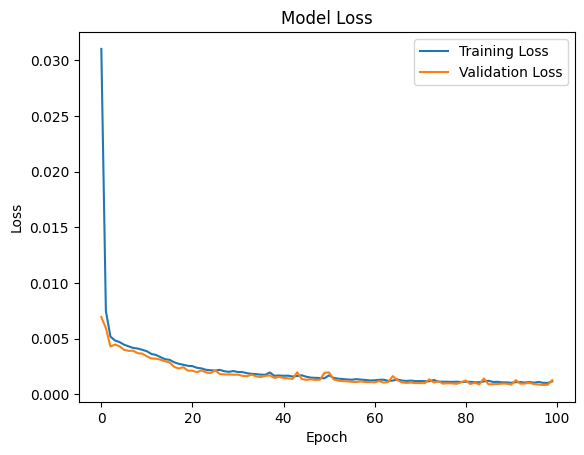

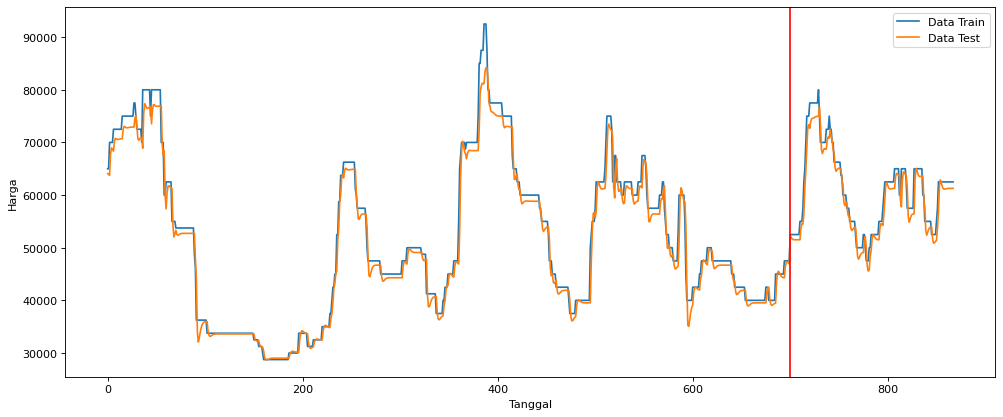

In [73]:
# Visualisasi loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()
# Plot hasil
plot_result(scaler.inverse_transform(trainY.reshape(-1,1)), scaler.inverse_transform(testY.reshape(-1,1)), scaler.inverse_transform(train_predict.reshape(-1,1)), scaler.inverse_transform(test_predict.reshape(-1,1)))

In [74]:
from joblib import dump, load
# Menyimpan model ke file H5
model.save('model_Cabai_Rawit_Hijau.h5')
# Menyimpan scaler
#dump(scaler, 'scaler_Beras.pkl')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 33ms/step


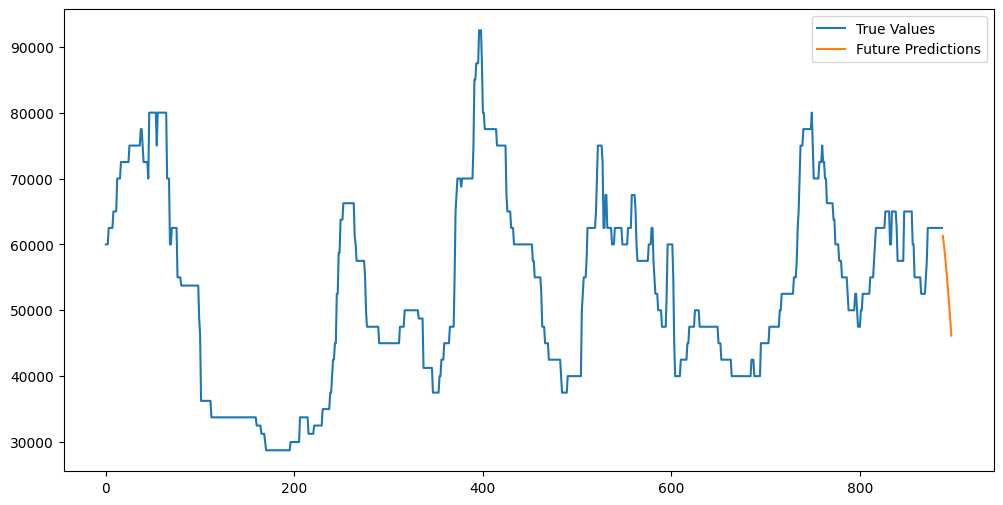

In [75]:
from keras.models import load_model
model_Cabai_Rawit_Hijau = load_model('model_Cabai_Rawit_Hijau.h5')

target = df['Cabai Rawit Hijau'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler.fit_transform(target)

# Predict future values
future_steps = 10  # Set the number of future steps you want to predict
future_data = scaled_target[-time_steps:, :]

future_predictions = []
for _ in range(future_steps):
    # Reshape the data to match the input shape of the model
    future_input = future_data.reshape((1, time_steps, 1))

    # Make the prediction
    future_pred = model_Cabai_Rawit_Hijau.predict(future_input)

    # Append the prediction to the results
    future_predictions.append(future_pred[0, 0])
    # Update the input data for the next prediction
    future_data = np.vstack((future_data[1:], future_pred))

# Inverse transform the predictions to the original scale
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(target, label='True Values')
plt.plot(np.arange(len(target) , len(target) + future_steps), future_predictions, label='Future Predictions')
plt.legend()
plt.show()

## FORCAST HARGA CABAI RAWIT MERAH

In [76]:
def get_train_test(file_path, split_percent):
    data = pd.read_csv("data_clean.csv")[["Cabai Rawit Merah"]]
    data = data.values.reshape(-1, 1)
    train_size = int(len(data) * split_percent)
    train_data, test_data = data[:train_size], data[train_size:]
    return train_data, test_data, data
def get_XY(data, time_steps):
    X, Y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        Y.append(data[i + time_steps, 0])
    return np.array(X).reshape(-1, time_steps, 1), np.array(Y)
def create_LSTM(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(LSTM(hidden_units, activation=activation[0], input_shape=input_shape))
    model.add(Dense(dense_units, activation=activation[1]))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model
def plot_result(trainY, testY, train_predict, test_predict):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.legend(['Data Train', 'Data Test'])
    plt.xlabel('Tanggal')
    plt.ylabel('Harga')

In [77]:
time_steps = 10
hidden_units = 50
dense_units = 1
epochs = 100
batch_size = 32
activation = ['tanh', 'tanh']
file_path = "data_clean.csv"
train_data, test_data, data = get_train_test(file_path, split_percent=0.8)

# Inisialisasi scaler
scaler = MinMaxScaler(feature_range=(0, 1))
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Menyiapkan data pelatihan dan pengujian
trainX, trainY = get_XY(train_data, time_steps)
testX, testY = get_XY(test_data, time_steps)

# Membuat model LSTM
model = create_LSTM(hidden_units=hidden_units, dense_units=dense_units, input_shape=(time_steps,1), activation=activation)

# Melatih model dengan menyimpan history
history = model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=2, validation_data=(testX, testY))

# Prediksi data pelatihan dan pengujian
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# Hitung MAPE
MAPE_train_LSTM = mean_absolute_percentage_error(scaler.inverse_transform(trainY.reshape(-1,1)), scaler.inverse_transform(train_predict))
MAPE_test_LSTM = mean_absolute_percentage_error(scaler.inverse_transform(testY.reshape(-1,1)), scaler.inverse_transform(test_predict.reshape(-1,1)))

# Hitung RMSE
RMSE_train_LSTM = np.sqrt(mean_squared_error(scaler.inverse_transform(trainY.reshape(-1,1)), scaler.inverse_transform(train_predict)))
RMSE_test_LSTM = np.sqrt(mean_squared_error(scaler.inverse_transform(testY.reshape(-1,1)), scaler.inverse_transform(test_predict)))

# Hitung MAE
MAE_train_LSTM = mean_absolute_error(scaler.inverse_transform(trainY.reshape(-1,1)), scaler.inverse_transform(train_predict))
MAE_test_LSTM = mean_absolute_error(scaler.inverse_transform(testY.reshape(-1,1)), scaler.inverse_transform(test_predict))

# Tampilkan MAPE, RMSE, dan MAE
print(f"MAPE_train_LSTM = {round(MAPE_train_LSTM * 100, 2)} %")
print(f"MAPE_test_LSTM = {round(MAPE_test_LSTM * 100, 2)} %")
print(f"RMSE_train_LSTM = {round(RMSE_train_LSTM, 2)}")
print(f"RMSE_test_LSTM = {round(RMSE_test_LSTM, 2)}")
print(f"MAE_train_LSTM = {round(MAE_train_LSTM, 2)}")
print(f"MAE_test_LSTM = {round(MAE_test_LSTM, 2)}")

Epoch 1/100
22/22 - 3s - loss: 0.0729 - val_loss: 0.0205 - 3s/epoch - 120ms/step
Epoch 2/100
22/22 - 0s - loss: 0.0165 - val_loss: 0.0222 - 171ms/epoch - 8ms/step
Epoch 3/100
22/22 - 0s - loss: 0.0114 - val_loss: 0.0153 - 155ms/epoch - 7ms/step
Epoch 4/100
22/22 - 0s - loss: 0.0096 - val_loss: 0.0134 - 161ms/epoch - 7ms/step
Epoch 5/100
22/22 - 0s - loss: 0.0091 - val_loss: 0.0127 - 159ms/epoch - 7ms/step
Epoch 6/100
22/22 - 0s - loss: 0.0087 - val_loss: 0.0119 - 156ms/epoch - 7ms/step
Epoch 7/100
22/22 - 0s - loss: 0.0085 - val_loss: 0.0113 - 164ms/epoch - 7ms/step
Epoch 8/100
22/22 - 0s - loss: 0.0080 - val_loss: 0.0106 - 173ms/epoch - 8ms/step
Epoch 9/100
22/22 - 0s - loss: 0.0074 - val_loss: 0.0101 - 165ms/epoch - 8ms/step
Epoch 10/100
22/22 - 0s - loss: 0.0069 - val_loss: 0.0100 - 153ms/epoch - 7ms/step
Epoch 11/100
22/22 - 0s - loss: 0.0065 - val_loss: 0.0087 - 152ms/epoch - 7ms/step
Epoch 12/100
22/22 - 0s - loss: 0.0059 - val_loss: 0.0078 - 170ms/epoch - 8ms/step
Epoch 13/100
2

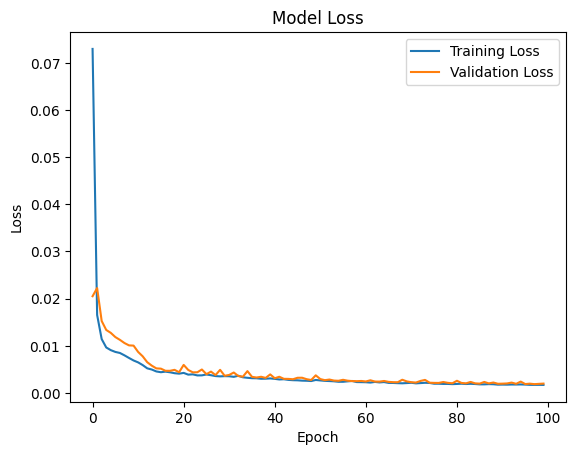

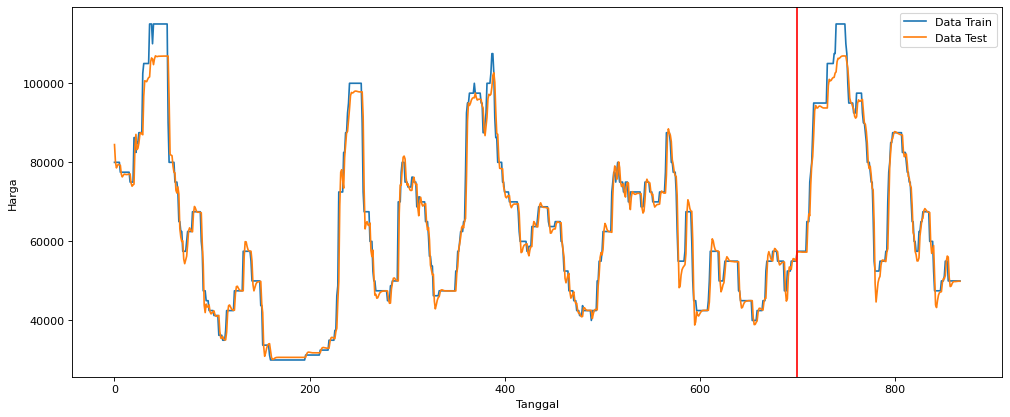

In [78]:
# Visualisasi loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()
# Plot hasil
plot_result(scaler.inverse_transform(trainY.reshape(-1,1)), scaler.inverse_transform(testY.reshape(-1,1)), scaler.inverse_transform(train_predict.reshape(-1,1)), scaler.inverse_transform(test_predict.reshape(-1,1)))

In [79]:
from joblib import dump, load
# Menyimpan model ke file H5
model.save('model_Cabai_Rawit_Merah.h5')
# Menyimpan scaler
#dump(scaler, 'scaler_Beras.pkl')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 42ms/step


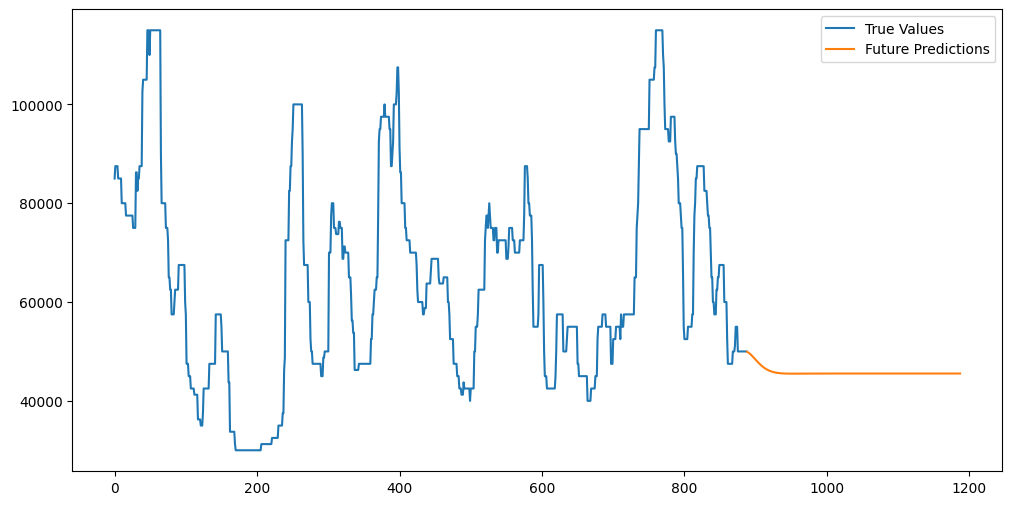

In [81]:
from keras.models import load_model
model_Cabai_Rawit_Merah = load_model('model_Cabai_Rawit_Merah.h5')

target = df['Cabai Rawit Merah'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler.fit_transform(target)

# Predict future values
future_steps = 300  # Set the number of future steps you want to predict
future_data = scaled_target[-time_steps:, :]

future_predictions = []
for _ in range(future_steps):
    # Reshape the data to match the input shape of the model
    future_input = future_data.reshape((1, time_steps, 1))

    # Make the prediction
    future_pred = model_Cabai_Rawit_Merah.predict(future_input)

    # Append the prediction to the results
    future_predictions.append(future_pred[0, 0])
    # Update the input data for the next prediction
    future_data = np.vstack((future_data[1:], future_pred))

# Inverse transform the predictions to the original scale
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(target, label='True Values')
plt.plot(np.arange(len(target) , len(target) + future_steps), future_predictions, label='Future Predictions')
plt.legend()
plt.show()

## FORCAST HARGA BAWANG MERAH

In [82]:
def get_train_test(file_path, split_percent):
    data = pd.read_csv("data_clean.csv")[["Bawang Merah"]]
    data = data.values.reshape(-1, 1)
    train_size = int(len(data) * split_percent)
    train_data, test_data = data[:train_size], data[train_size:]
    return train_data, test_data, data
def get_XY(data, time_steps):
    X, Y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        Y.append(data[i + time_steps, 0])
    return np.array(X).reshape(-1, time_steps, 1), np.array(Y)
def create_LSTM(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(LSTM(hidden_units, activation=activation[0], input_shape=input_shape))
    model.add(Dense(dense_units, activation=activation[1]))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model
def plot_result(trainY, testY, train_predict, test_predict):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.legend(['Data Train', 'Data Test'])
    plt.xlabel('Tanggal')
    plt.ylabel('Harga')

In [83]:
time_steps = 10
hidden_units = 50
dense_units = 1
epochs = 100
batch_size = 32
activation = ['tanh', 'tanh']
file_path = "data_clean.csv"
train_data, test_data, data = get_train_test(file_path, split_percent=0.8)

# Inisialisasi scaler
scaler = MinMaxScaler(feature_range=(0, 1))
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Menyiapkan data pelatihan dan pengujian
trainX, trainY = get_XY(train_data, time_steps)
testX, testY = get_XY(test_data, time_steps)

# Membuat model LSTM
model = create_LSTM(hidden_units=hidden_units, dense_units=dense_units, input_shape=(time_steps,1), activation=activation)

# Melatih model dengan menyimpan history
history = model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=2, validation_data=(testX, testY))

# Prediksi data pelatihan dan pengujian
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# Hitung MAPE
MAPE_train_LSTM = mean_absolute_percentage_error(scaler.inverse_transform(trainY.reshape(-1,1)), scaler.inverse_transform(train_predict))
MAPE_test_LSTM = mean_absolute_percentage_error(scaler.inverse_transform(testY.reshape(-1,1)), scaler.inverse_transform(test_predict.reshape(-1,1)))

# Hitung RMSE
RMSE_train_LSTM = np.sqrt(mean_squared_error(scaler.inverse_transform(trainY.reshape(-1,1)), scaler.inverse_transform(train_predict)))
RMSE_test_LSTM = np.sqrt(mean_squared_error(scaler.inverse_transform(testY.reshape(-1,1)), scaler.inverse_transform(test_predict)))

# Hitung MAE
MAE_train_LSTM = mean_absolute_error(scaler.inverse_transform(trainY.reshape(-1,1)), scaler.inverse_transform(train_predict))
MAE_test_LSTM = mean_absolute_error(scaler.inverse_transform(testY.reshape(-1,1)), scaler.inverse_transform(test_predict))

# Tampilkan MAPE, RMSE, dan MAE
print(f"MAPE_train_LSTM = {round(MAPE_train_LSTM * 100, 2)} %")
print(f"MAPE_test_LSTM = {round(MAPE_test_LSTM * 100, 2)} %")
print(f"RMSE_train_LSTM = {round(RMSE_train_LSTM, 2)}")
print(f"RMSE_test_LSTM = {round(RMSE_test_LSTM, 2)}")
print(f"MAE_train_LSTM = {round(MAE_train_LSTM, 2)}")
print(f"MAE_test_LSTM = {round(MAE_test_LSTM, 2)}")

Epoch 1/100
22/22 - 5s - loss: 0.0369 - val_loss: 0.0187 - 5s/epoch - 239ms/step
Epoch 2/100
22/22 - 0s - loss: 0.0088 - val_loss: 0.0145 - 167ms/epoch - 8ms/step
Epoch 3/100
22/22 - 0s - loss: 0.0039 - val_loss: 0.0080 - 177ms/epoch - 8ms/step
Epoch 4/100
22/22 - 0s - loss: 0.0026 - val_loss: 0.0064 - 224ms/epoch - 10ms/step
Epoch 5/100
22/22 - 0s - loss: 0.0027 - val_loss: 0.0066 - 159ms/epoch - 7ms/step
Epoch 6/100
22/22 - 0s - loss: 0.0025 - val_loss: 0.0065 - 169ms/epoch - 8ms/step
Epoch 7/100
22/22 - 0s - loss: 0.0024 - val_loss: 0.0067 - 188ms/epoch - 9ms/step
Epoch 8/100
22/22 - 0s - loss: 0.0023 - val_loss: 0.0062 - 292ms/epoch - 13ms/step
Epoch 9/100
22/22 - 1s - loss: 0.0022 - val_loss: 0.0065 - 533ms/epoch - 24ms/step
Epoch 10/100
22/22 - 0s - loss: 0.0022 - val_loss: 0.0062 - 371ms/epoch - 17ms/step
Epoch 11/100
22/22 - 0s - loss: 0.0021 - val_loss: 0.0054 - 176ms/epoch - 8ms/step
Epoch 12/100
22/22 - 0s - loss: 0.0020 - val_loss: 0.0050 - 190ms/epoch - 9ms/step
Epoch 13/1

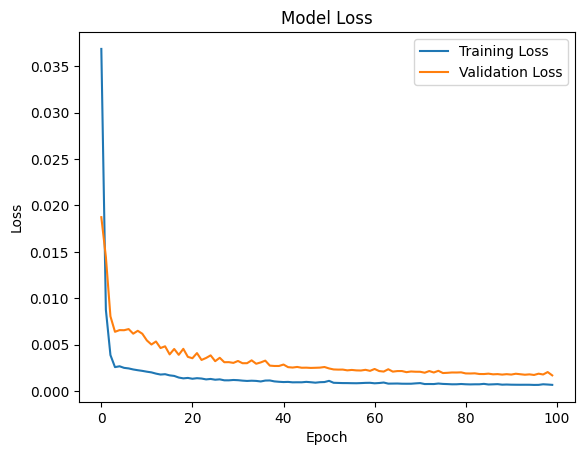

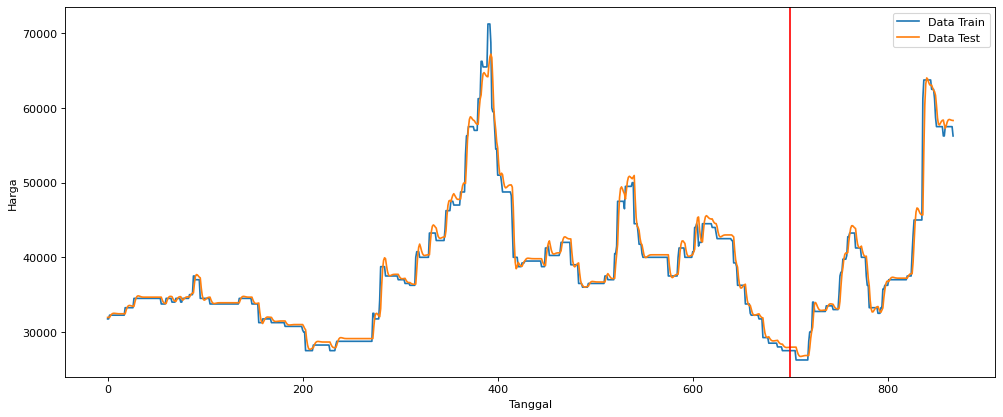

In [84]:
# Visualisasi loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()
# Plot hasil
plot_result(scaler.inverse_transform(trainY.reshape(-1,1)), scaler.inverse_transform(testY.reshape(-1,1)), scaler.inverse_transform(train_predict.reshape(-1,1)), scaler.inverse_transform(test_predict.reshape(-1,1)))

In [85]:
from joblib import dump, load
# Menyimpan model ke file H5
model.save('model_Bawang_Merah.h5')
# Menyimpan scaler
#dump(scaler, 'scaler_Beras.pkl')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 22ms/step


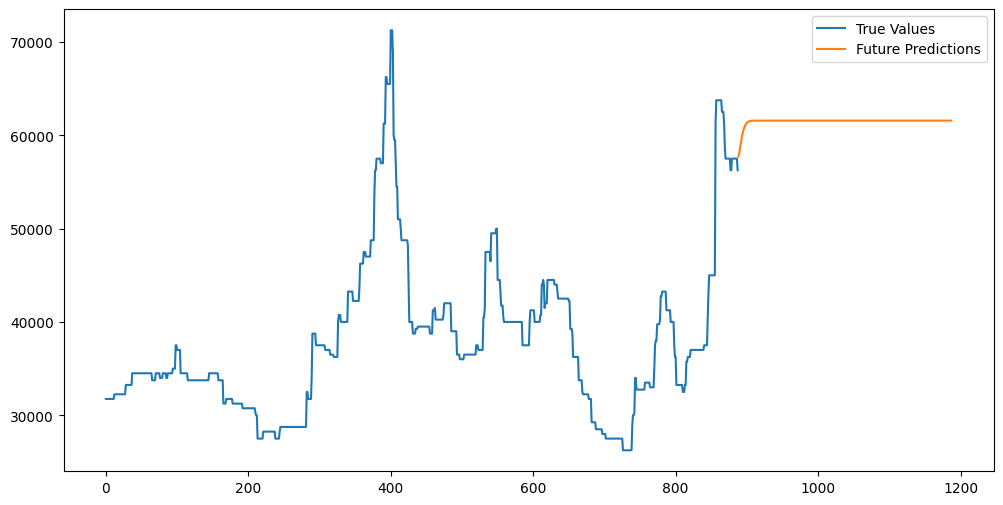

In [88]:
from keras.models import load_model
model_Bawang_Merah = load_model('model_Bawang_Merah.h5')

target = df['Bawang Merah'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler.fit_transform(target)

# Predict future values
future_steps = 300  # Set the number of future steps you want to predict
future_data = scaled_target[-time_steps:, :]

future_predictions = []
for _ in range(future_steps):
    # Reshape the data to match the input shape of the model
    future_input = future_data.reshape((1, time_steps, 1))

    # Make the prediction
    future_pred = model_Bawang_Merah.predict(future_input)

    # Append the prediction to the results
    future_predictions.append(future_pred[0, 0])
    # Update the input data for the next prediction
    future_data = np.vstack((future_data[1:], future_pred))

# Inverse transform the predictions to the original scale
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(target, label='True Values')
plt.plot(np.arange(len(target) , len(target) + future_steps), future_predictions, label='Future Predictions')
plt.legend()
plt.show()

## FORCAST HARGA BAWANG PUTIH

In [89]:
def get_train_test(file_path, split_percent):
    data = pd.read_csv("data_clean.csv")[["Bawang Putih"]]
    data = data.values.reshape(-1, 1)
    train_size = int(len(data) * split_percent)
    train_data, test_data = data[:train_size], data[train_size:]
    return train_data, test_data, data
def get_XY(data, time_steps):
    X, Y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        Y.append(data[i + time_steps, 0])
    return np.array(X).reshape(-1, time_steps, 1), np.array(Y)
def create_LSTM(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(LSTM(hidden_units, activation=activation[0], input_shape=input_shape))
    model.add(Dense(dense_units, activation=activation[1]))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model
def plot_result(trainY, testY, train_predict, test_predict):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.legend(['Data Train', 'Data Test'])
    plt.xlabel('Tanggal')
    plt.ylabel('Harga')

In [90]:
time_steps = 10
hidden_units = 50
dense_units = 1
epochs = 100
batch_size = 32
activation = ['tanh', 'tanh']
file_path = "data_clean.csv"
train_data, test_data, data = get_train_test(file_path, split_percent=0.8)

# Inisialisasi scaler
scaler = MinMaxScaler(feature_range=(0, 1))
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Menyiapkan data pelatihan dan pengujian
trainX, trainY = get_XY(train_data, time_steps)
testX, testY = get_XY(test_data, time_steps)

# Membuat model LSTM
model = create_LSTM(hidden_units=hidden_units, dense_units=dense_units, input_shape=(time_steps,1), activation=activation)

# Melatih model dengan menyimpan history
history = model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=2, validation_data=(testX, testY))

# Prediksi data pelatihan dan pengujian
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# Hitung MAPE
MAPE_train_LSTM = mean_absolute_percentage_error(scaler.inverse_transform(trainY.reshape(-1,1)), scaler.inverse_transform(train_predict))
MAPE_test_LSTM = mean_absolute_percentage_error(scaler.inverse_transform(testY.reshape(-1,1)), scaler.inverse_transform(test_predict.reshape(-1,1)))

# Hitung RMSE
RMSE_train_LSTM = np.sqrt(mean_squared_error(scaler.inverse_transform(trainY.reshape(-1,1)), scaler.inverse_transform(train_predict)))
RMSE_test_LSTM = np.sqrt(mean_squared_error(scaler.inverse_transform(testY.reshape(-1,1)), scaler.inverse_transform(test_predict)))

# Hitung MAE
MAE_train_LSTM = mean_absolute_error(scaler.inverse_transform(trainY.reshape(-1,1)), scaler.inverse_transform(train_predict))
MAE_test_LSTM = mean_absolute_error(scaler.inverse_transform(testY.reshape(-1,1)), scaler.inverse_transform(test_predict))

# Tampilkan MAPE, RMSE, dan MAE
print(f"MAPE_train_LSTM = {round(MAPE_train_LSTM * 100, 2)} %")
print(f"MAPE_test_LSTM = {round(MAPE_test_LSTM * 100, 2)} %")
print(f"RMSE_train_LSTM = {round(RMSE_train_LSTM, 2)}")
print(f"RMSE_test_LSTM = {round(RMSE_test_LSTM, 2)}")
print(f"MAE_train_LSTM = {round(MAE_train_LSTM, 2)}")
print(f"MAE_test_LSTM = {round(MAE_test_LSTM, 2)}")

Epoch 1/100
22/22 - 3s - loss: 0.0406 - val_loss: 0.0401 - 3s/epoch - 124ms/step
Epoch 2/100
22/22 - 0s - loss: 0.0065 - val_loss: 0.0277 - 166ms/epoch - 8ms/step
Epoch 3/100
22/22 - 0s - loss: 0.0031 - val_loss: 0.0276 - 158ms/epoch - 7ms/step
Epoch 4/100
22/22 - 0s - loss: 0.0029 - val_loss: 0.0272 - 157ms/epoch - 7ms/step
Epoch 5/100
22/22 - 0s - loss: 0.0028 - val_loss: 0.0267 - 169ms/epoch - 8ms/step
Epoch 6/100
22/22 - 0s - loss: 0.0027 - val_loss: 0.0263 - 161ms/epoch - 7ms/step
Epoch 7/100
22/22 - 0s - loss: 0.0027 - val_loss: 0.0261 - 162ms/epoch - 7ms/step
Epoch 8/100
22/22 - 0s - loss: 0.0026 - val_loss: 0.0257 - 183ms/epoch - 8ms/step
Epoch 9/100
22/22 - 0s - loss: 0.0026 - val_loss: 0.0254 - 172ms/epoch - 8ms/step
Epoch 10/100
22/22 - 0s - loss: 0.0025 - val_loss: 0.0252 - 153ms/epoch - 7ms/step
Epoch 11/100
22/22 - 0s - loss: 0.0024 - val_loss: 0.0249 - 169ms/epoch - 8ms/step
Epoch 12/100
22/22 - 0s - loss: 0.0024 - val_loss: 0.0247 - 159ms/epoch - 7ms/step
Epoch 13/100
2

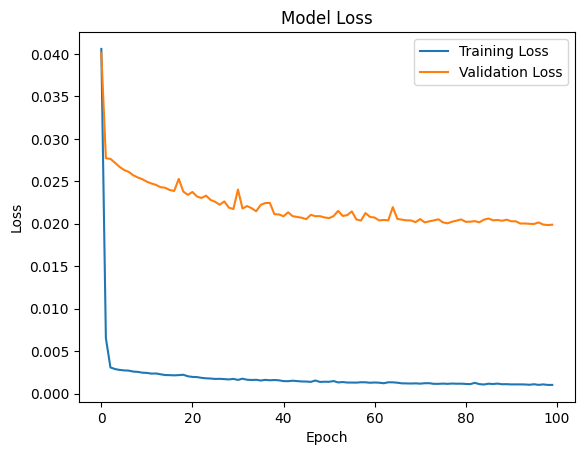

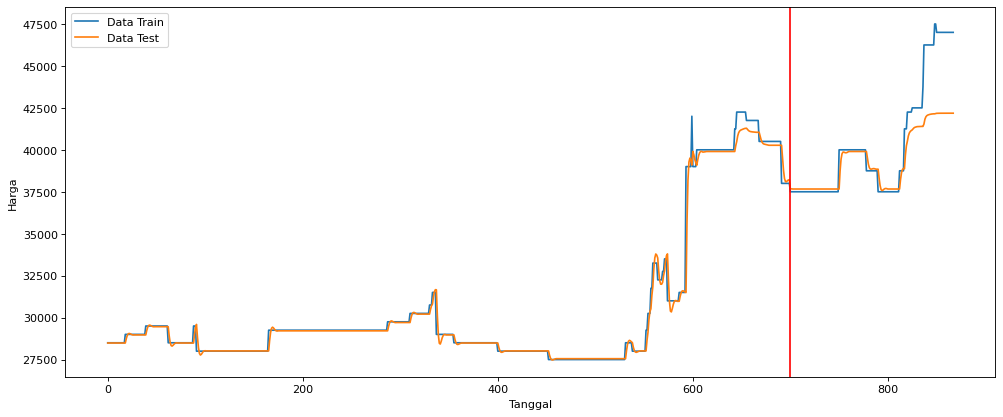

In [91]:
# Visualisasi loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()
# Plot hasil
plot_result(scaler.inverse_transform(trainY.reshape(-1,1)), scaler.inverse_transform(testY.reshape(-1,1)), scaler.inverse_transform(train_predict.reshape(-1,1)), scaler.inverse_transform(test_predict.reshape(-1,1)))

In [92]:
from joblib import dump, load
# Menyimpan model ke file H5
model.save('model_Bawang_Putih.h5')
# Menyimpan scaler
#dump(scaler, 'scaler_Beras.pkl')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 39ms/step


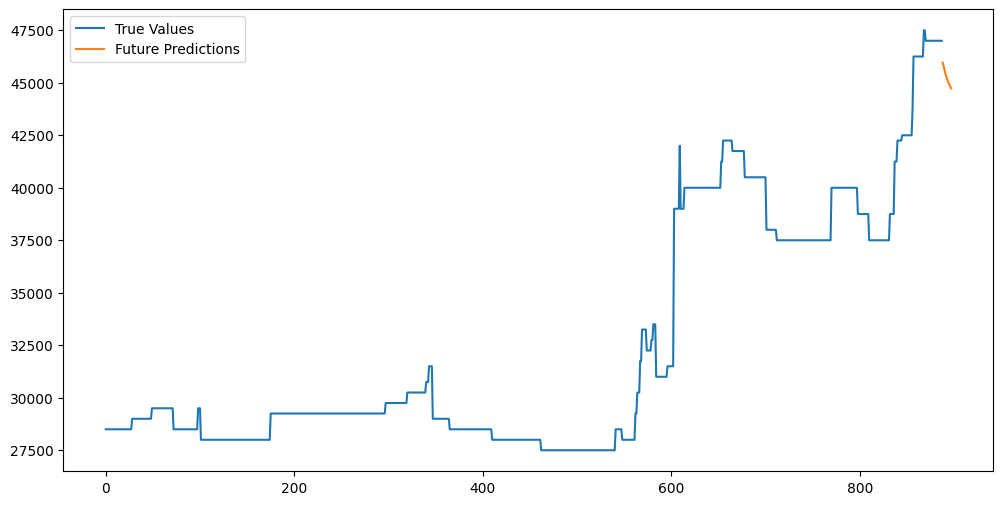

In [93]:
from keras.models import load_model
model_Bawang_Putih = load_model('model_Bawang_Putih.h5')

target = df['Bawang Putih'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler.fit_transform(target)

# Predict future values
future_steps = 10  # Set the number of future steps you want to predict
future_data = scaled_target[-time_steps:, :]

future_predictions = []
for _ in range(future_steps):
    # Reshape the data to match the input shape of the model
    future_input = future_data.reshape((1, time_steps, 1))

    # Make the prediction
    future_pred = model_Bawang_Putih.predict(future_input)

    # Append the prediction to the results
    future_predictions.append(future_pred[0, 0])
    # Update the input data for the next prediction
    future_data = np.vstack((future_data[1:], future_pred))

# Inverse transform the predictions to the original scale
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(target, label='True Values')
plt.plot(np.arange(len(target) , len(target) + future_steps), future_predictions, label='Future Predictions')
plt.legend()
plt.show()